<a href="https://colab.research.google.com/github/rossanez/TKGAnalyzer/blob/master/TKG_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run only once to install the dependencies
import sys

!pip install -q rdflib networkx matplotlib
!{sys.executable} -m pip install rdflib networkx matplotlib --user

     |████████████████████████████████| 235kB 2.8MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
from networkx import Graph as NXGraph

In [ ]:
tkgs = {'2017': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2017/merged_kg.ttl',
        '2018': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2018/merged_kg.ttl',
        '2019': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2019/merged_kg.ttl'}

nxgs = {}
for tkg in tkgs.keys():
    rdfg = RDFGraph()
    rdfg.parse(tkgs[tkg], format='turtle')
    print('Loaded TKG {}'.format(tkg))
    nxg = rdflib_to_networkx_graph(rdfg)
    print(' - Converted to complex network: {} nodes and {} edges'.format(nxg.number_of_nodes(), nxg.number_of_edges()))
    print(' -- Network density: {}'.format(nx.density(nxg)))
    nxgs[tkg] = nxg

Loaded TKG 2017
 - Converted to complex network: 7921 nodes and 10789 edges
 -- Network density: 0.0003439584584642027
Loaded TKG 2018
 - Converted to complex network: 7445 nodes and 10274 edges
 -- Network density: 0.0003707647953161082
Loaded TKG 2019
 - Converted to complex network: 8261 nodes and 11499 edges
 -- Network density: 0.00033703686009086716


In [ ]:
def get_centrality(method=nx.degree_centrality):
    nkgs_degrees = {}
    nkg_index = 0
    for nxg in nxgs.keys():
        top_keys = []
        top_values = []

        dc = method(nxgs[nxg])
        degrees = dict()
        for key, value in dc.items():
            if 'cso' in key:
                if not key in nkgs_degrees.keys():
                    lst = [0] * len(nxgs)
                else:
                    lst = nkgs_degrees[key]
                lst[nkg_index] = value
                nkgs_degrees[key] = lst

                top_keys.append(key)
                top_values.append(value)
        
        nkg_index += 1

        n = 20
        max_indexes = sorted(range(len(top_values)), key = lambda sub: top_values[sub])[-n:]
        print('Top {} values for {}'.format(n, nxg))
        for i in reversed(range(len(max_indexes))):
            print(' - {}: {}'.format(top_keys[max_indexes[i]], top_values[max_indexes[i]]))

    return nkgs_degrees

def plot(degrees, indexes, enlarge=False):
    yrs_degrees = np.array(list(degrees.values()))
    idx = np.arange(len(yrs_degrees[:,0]))
    if enlarge:
        fig = plt.figure(figsize=(18, 16), dpi= 200, facecolor='w', edgecolor='k')
    else:
        fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    colours=['r', 'g', 'b'] # add more if required!
    bar_width = 0.25
    for i in indexes:
        ax.bar(idx + i*bar_width, yrs_degrees[:,i], color=colours[i], width = bar_width, align='edge')

    ax.set_xticks(idx)
    if len(indexes) > 1:
        ax.legend(list(tkgs.keys())[:len(indexes)])
    ax.set_xlabel('Concept')
    ax.set_ylabel('Degree')
    ax.set_title('Centrality vs Concepts')

def plot_combined(degrees, enlarge=False):
    plot(degrees, range(len(tkgs.keys())), enlarge)

def plot_all(degrees):
    for i in range(len(tkgs.keys())):
        plot(degrees, [i], enlarge=True)
    plot_combined(degrees, enlarge=True)

################################################################################

def get_examples(degrees):
    max = 3

    single_yrs = {}
    two_yrs = {}
    all_yrs = {}
    max_per_year = {}
    max_year0 = ('', [0, 0, 0])
    max_year1 = ('', [0, 0, 0])
    max_year2 = ('', [0, 0, 0])

    for key in degrees.keys():
        values = degrees[key]

        if values[0] > max_year0[1][0]:
            max_year0 = (key, values)
        if values[1] > max_year1[1][1]:
            max_year1 = (key, values)
        if values[2] > max_year2[1][2]:
            max_year2 = (key, values)

        if len(all_yrs) < max and \
            values[0] > 0 and values[1] > 0 and values[2] > 0:
            #if (len(all_yrs) == 0 and \
            #    values[0] < values[1] and values[1] < values[2]) or \
            #   (len(all_yrs) == 1 and \
            #    values[0] > values[1] > 0 and values[1] > values[2]) or \
            #   len(all_yrs) == 2:
                all_yrs[key] = values

        if (len(two_yrs) == 0 and values[0] == 0 and values[1] > 0 and values[2] > 0) or \
           (len(two_yrs) == 1 and values[0] > 0 and values[1] == 0 and values[2] > 0) or \
           (len(two_yrs) == 2 and values[0] > 0 and values[1] > 0 and values[2] == 0):
            two_yrs[key] = values

        if (len(single_yrs) == 0 and values[0] > 0 and values[1] == 0 and values[2] == 0) or \
           (len(single_yrs) == 1 and values[0] == 0 and values[1] > 0 and values[2] == 0) or \
           (len(single_yrs) ==2 and values[0] == 0 and values[1] == 0 and values[2] > 0):
            single_yrs[key] = values
 
    max_per_year[max_year0[0]] = max_year0[1]
    max_per_year[max_year1[0]] = max_year1[1]
    max_per_year[max_year2[0]] = max_year2[1]

    return {**all_yrs, **two_yrs, **single_yrs, **max_per_year}
    
    

In [ ]:
deg_centrality = get_centrality(nx.degree_centrality)

Top 20 values for 2017
 - https://cso.kmi.open.ac.uk/topics/query_languages: 0.000505050505050505
 - https://cso.kmi.open.ac.uk/topics/natural_language_questions: 0.000505050505050505
 - https://cso.kmi.open.ac.uk/topics/ontology_alignment: 0.000505050505050505
 - https://cso.kmi.open.ac.uk/topics/inference: 0.000505050505050505
 - https://cso.kmi.open.ac.uk/topics/optimization: 0.000505050505050505
 - https://cso.kmi.open.ac.uk/topics/semantics: 0.000505050505050505
 - https://cso.kmi.open.ac.uk/topics/rdf_graph: 0.000505050505050505
 - https://cso.kmi.open.ac.uk/topics/natural_language: 0.0003787878787878788
 - https://cso.kmi.open.ac.uk/topics/description_logics: 0.0003787878787878788
 - https://cso.kmi.open.ac.uk/topics/word_embeddings: 0.0003787878787878788
 - https://cso.kmi.open.ac.uk/topics/description_logic: 0.0003787878787878788
 - https://cso.kmi.open.ac.uk/topics/reasoner: 0.0003787878787878788
 - https://cso.kmi.open.ac.uk/topics/factor_graphs: 0.0003787878787878788
 - htt

DEGREE CENTRALITY


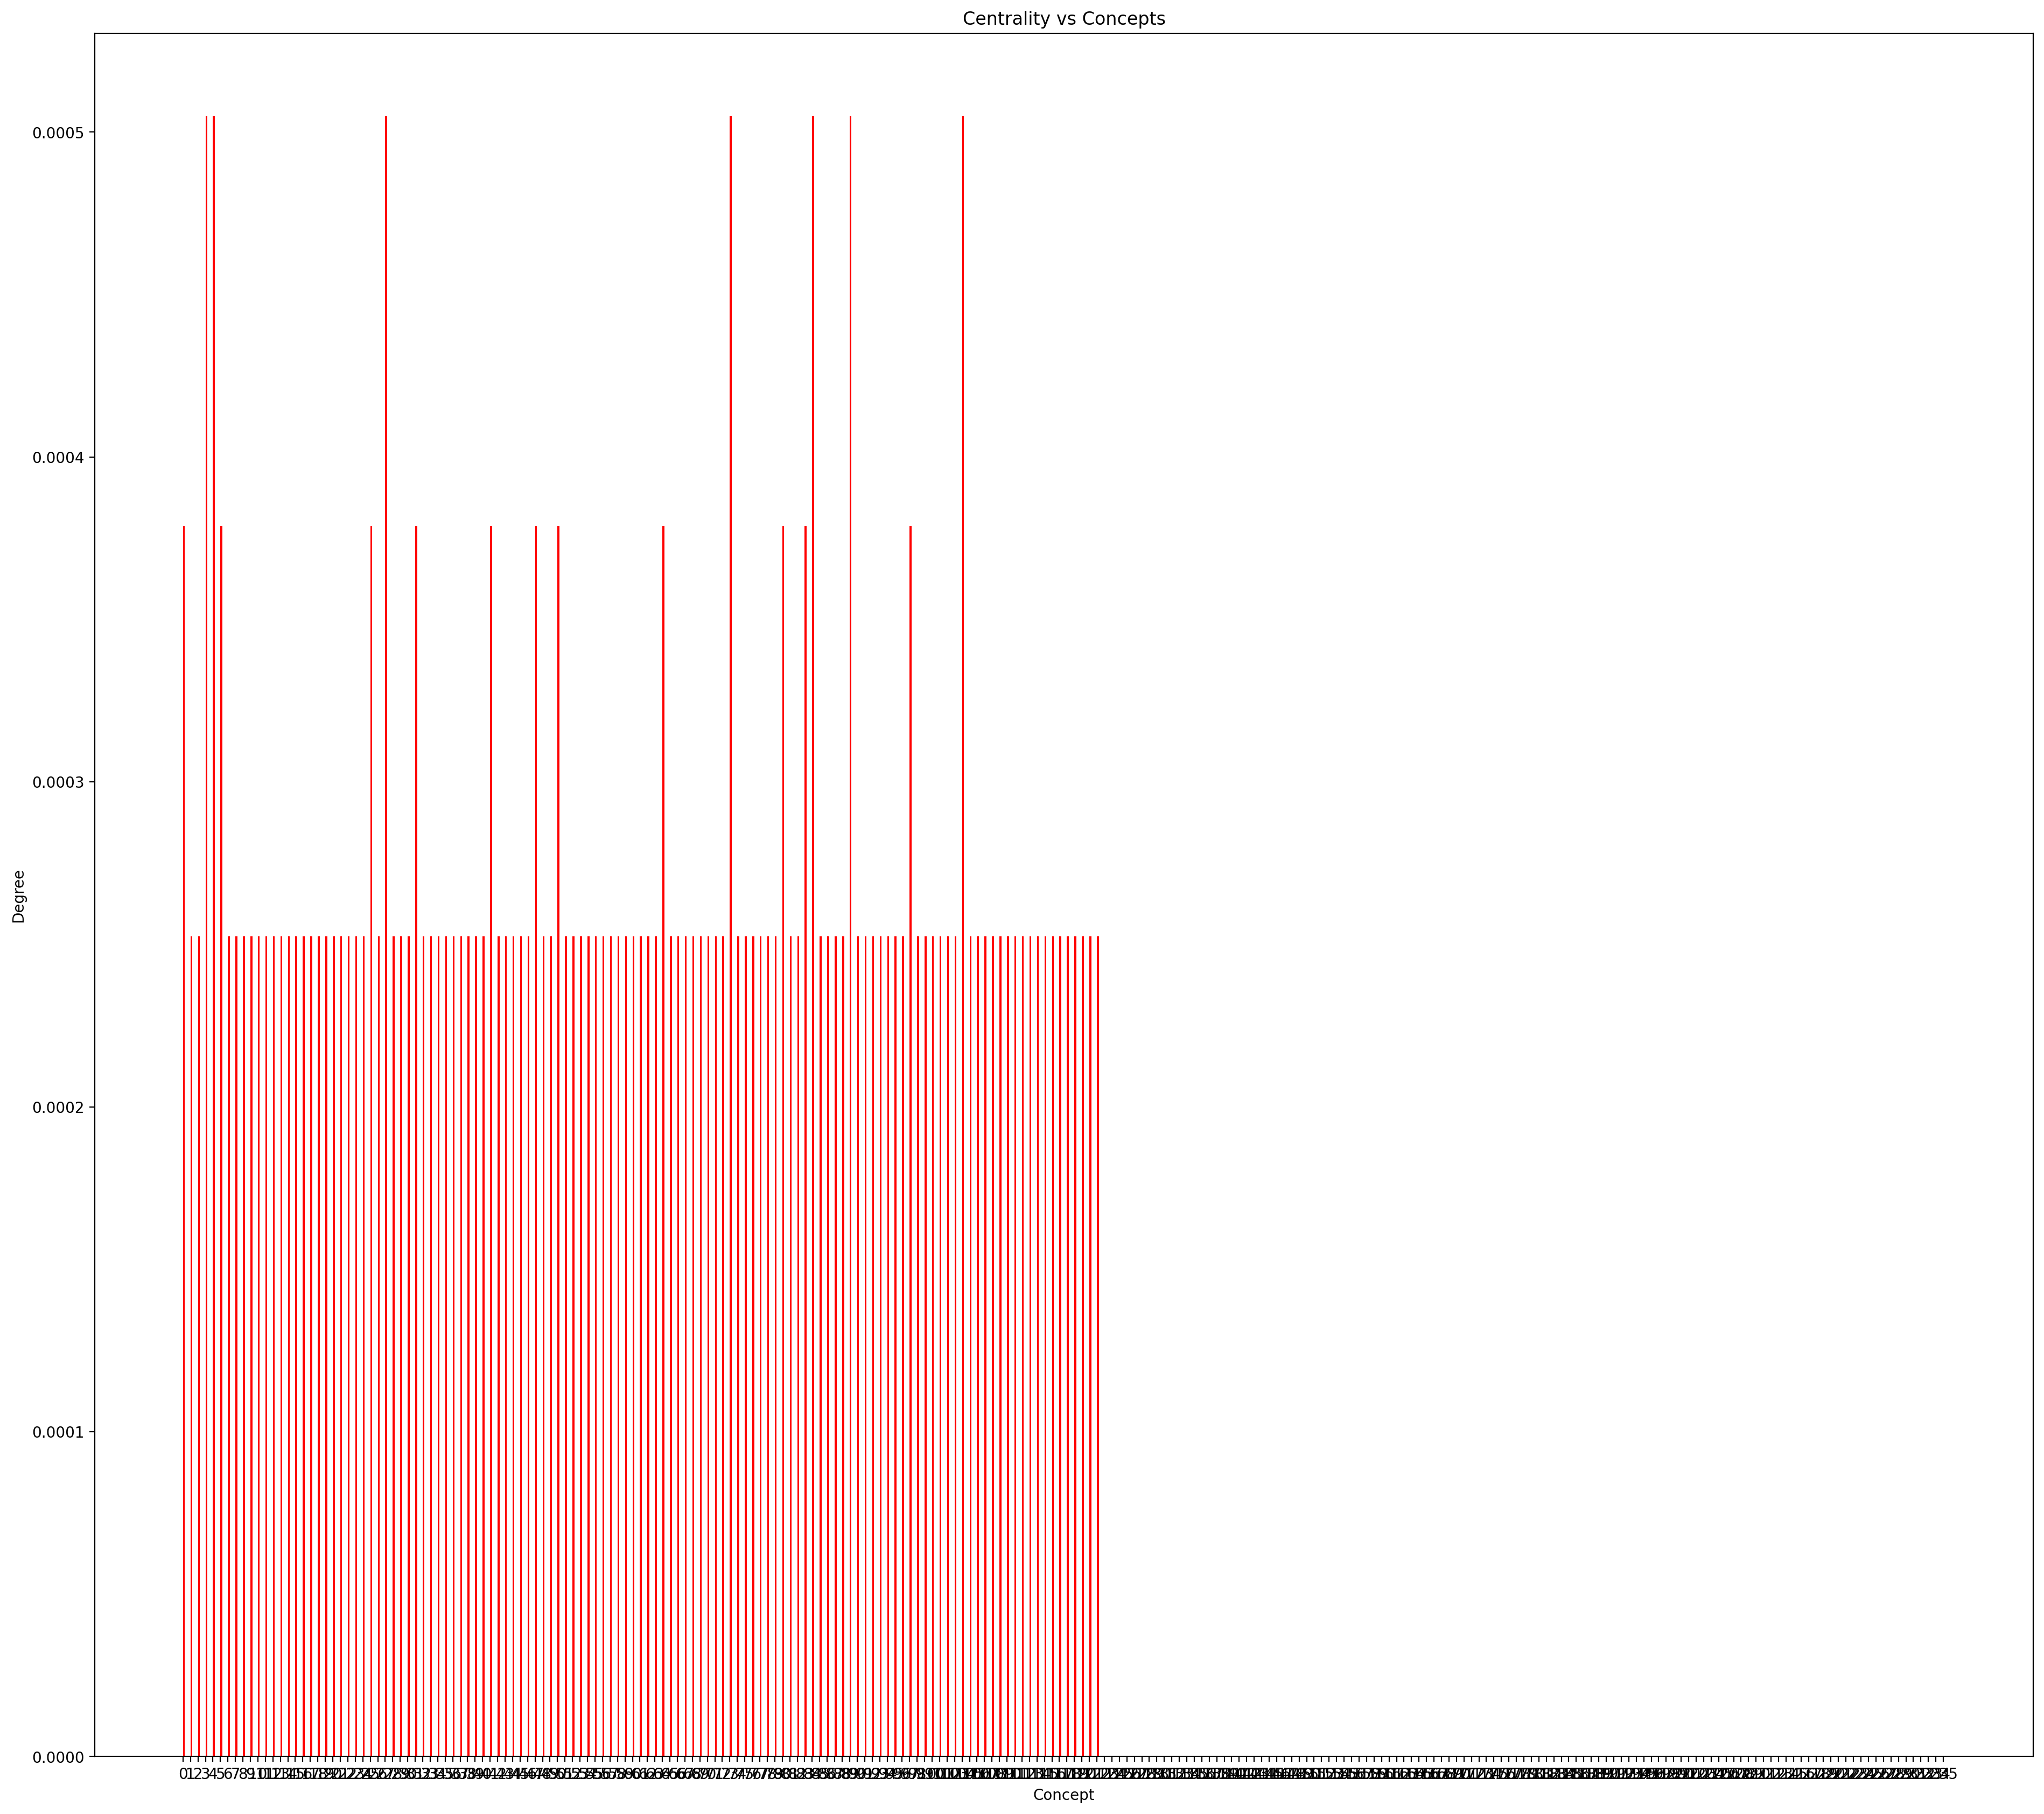

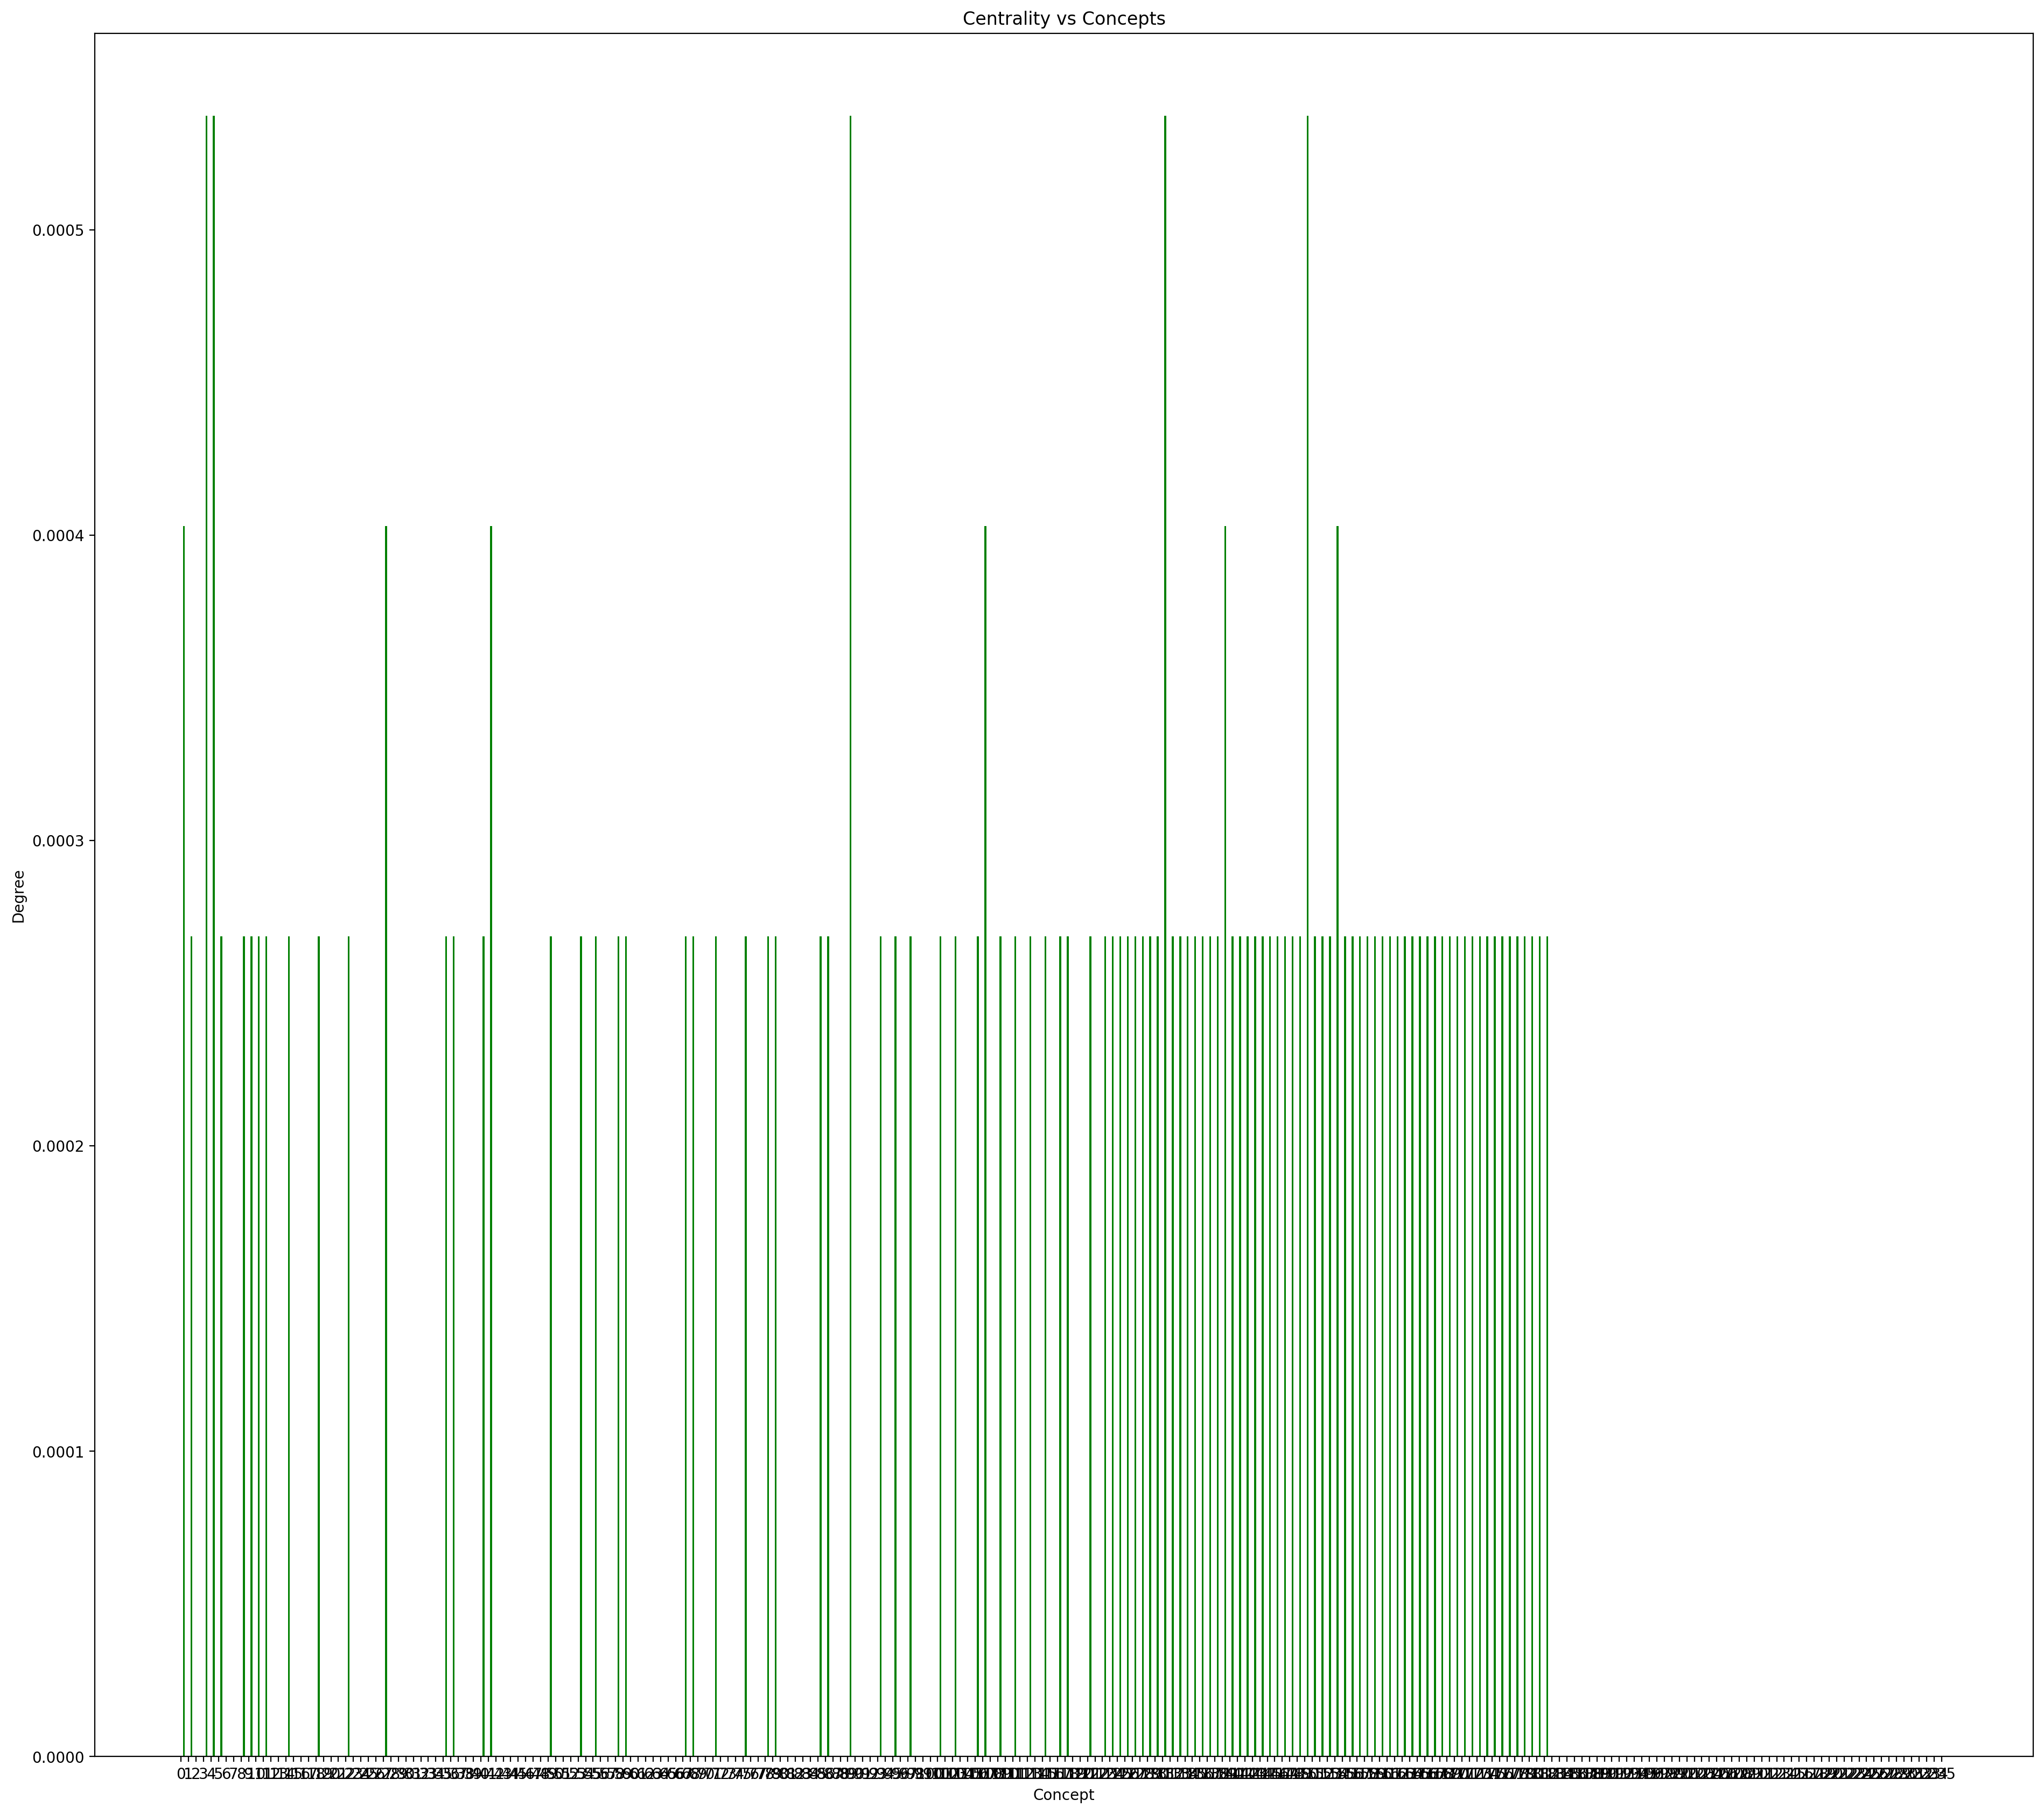

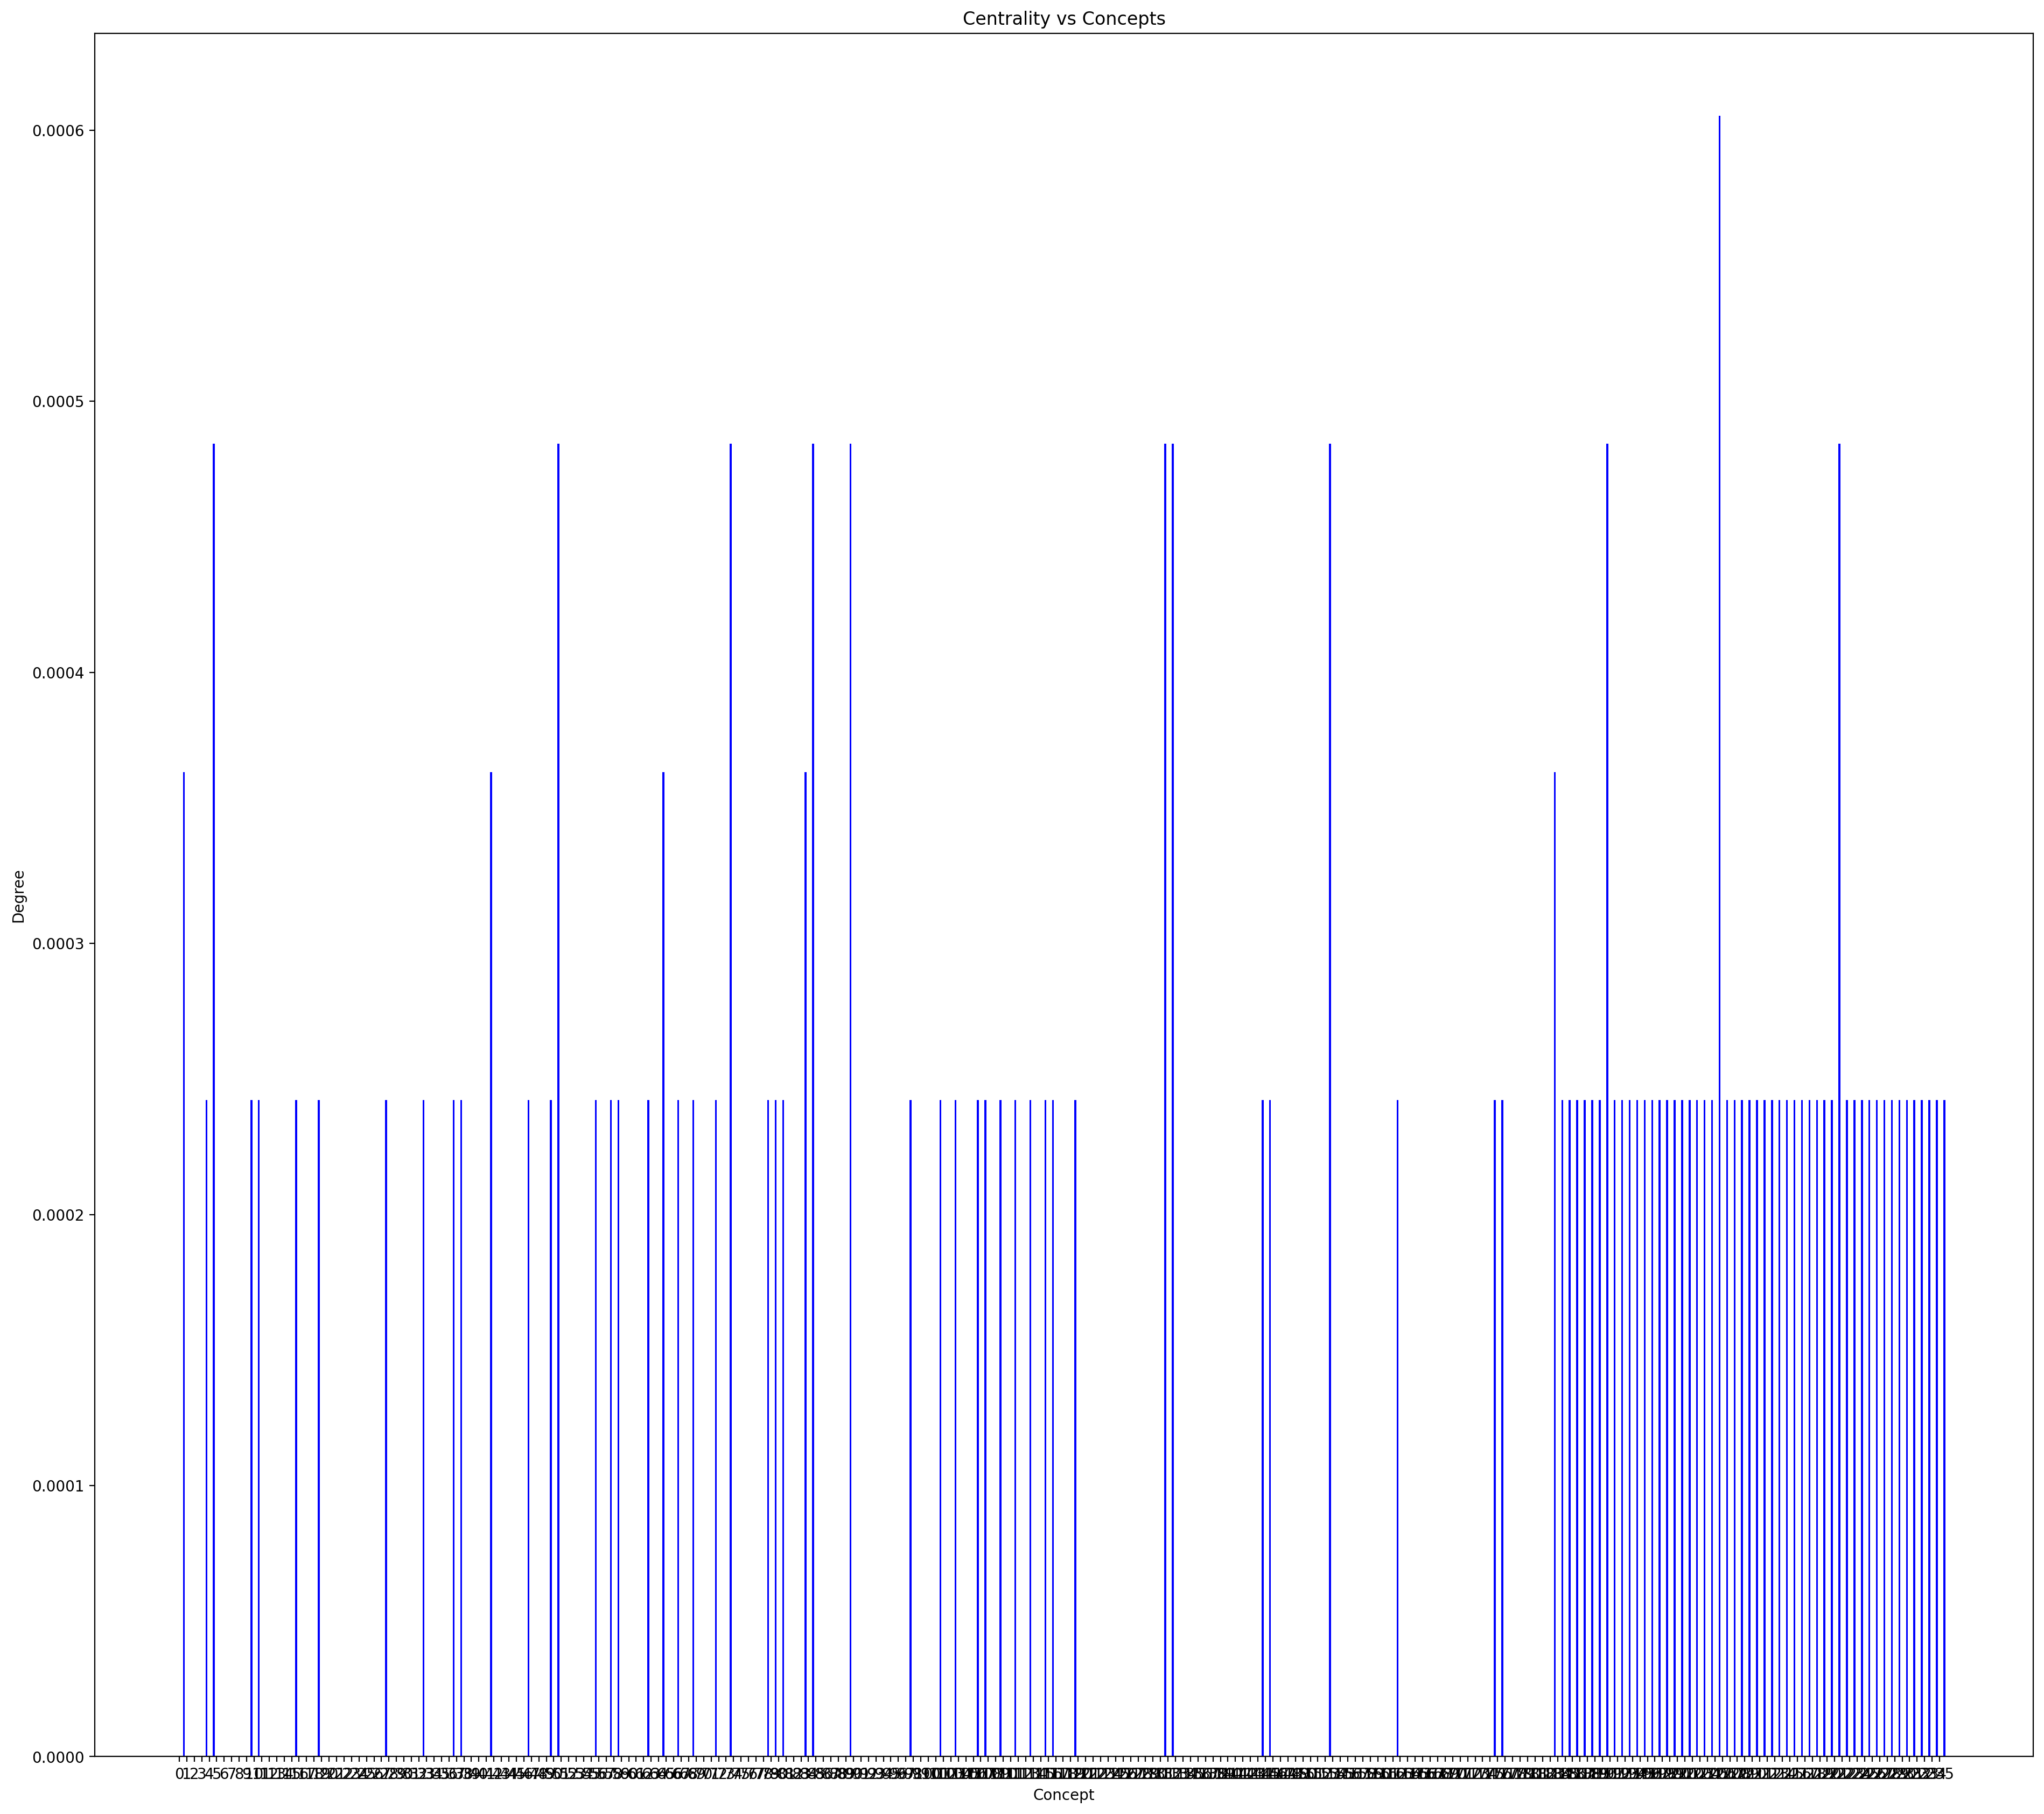

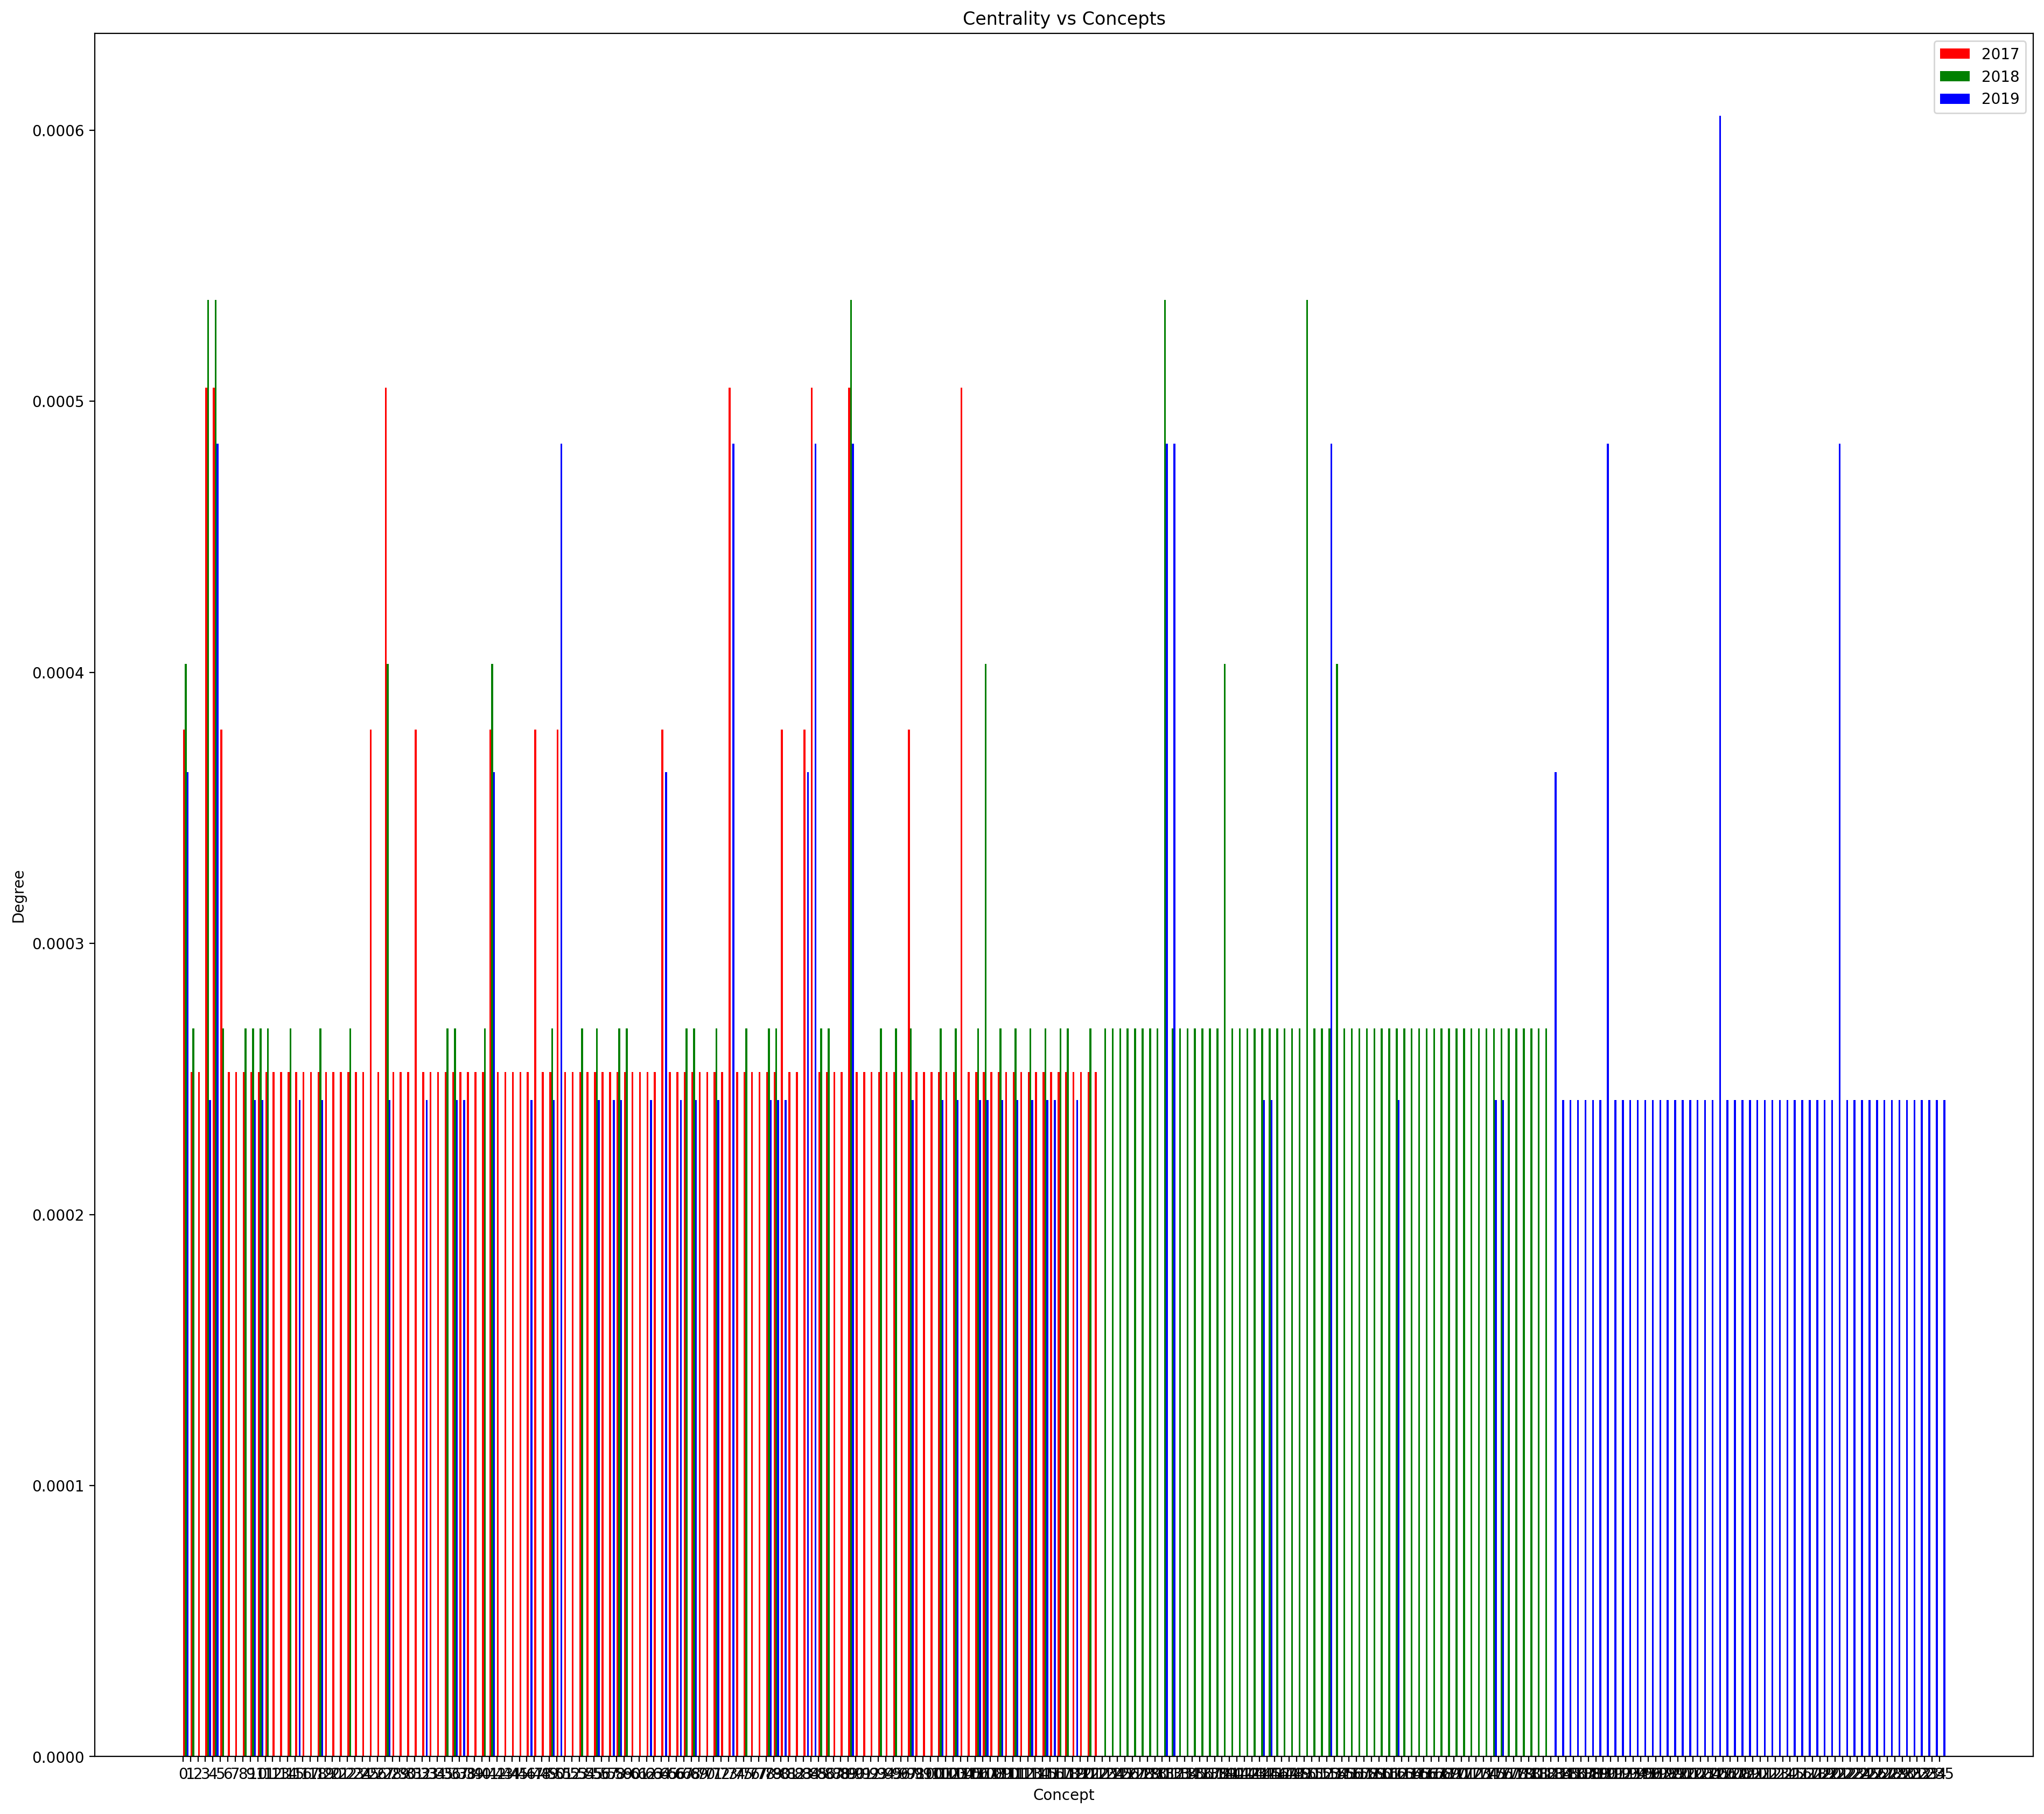

In [ ]:
print('DEGREE CENTRALITY')
plot_all(deg_centrality)

{rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/knowledge_bases'): [0.0003787878787878788, 0.0004030091348737238, 0.0003631961259079903], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/rdf_graph'): [0.000505050505050505, 0.0005373455131649651, 0.00024213075060532688], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/semantics'): [0.000505050505050505, 0.0005373455131649651, 0.00048426150121065375], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/database'): [0, 0.0005373455131649651, 0.00048426150121065375], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/interactive_exploration'): [0.0002525252525252525, 0, 0], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/user_interfaces'): [0, 0.00026867275658248256, 0], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/syntactic_information'): [0, 0, 0.0003631961259079903], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/qa_system'): [0, 0, 0.0006053268765133172]}


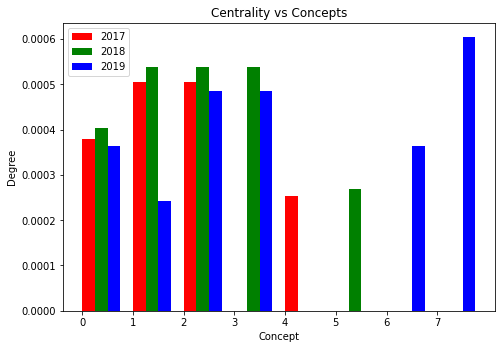

In [ ]:
deg_examples = get_examples(deg_centrality)
plot_combined(deg_examples)
print(deg_examples)

In [ ]:
eig_centrality = get_centrality(nx.eigenvector_centrality)

Top 20 values for 2017
 - https://cso.kmi.open.ac.uk/topics/rdf_data: 0.002891154771029406
 - https://cso.kmi.open.ac.uk/topics/data_mining: 0.0028014313687906734
 - https://cso.kmi.open.ac.uk/topics/linked_data: 0.002645712534484543
 - https://cso.kmi.open.ac.uk/topics/description_logic: 0.0015802410725255821
 - https://cso.kmi.open.ac.uk/topics/machine_translation: 0.001576108625859414
 - https://cso.kmi.open.ac.uk/topics/description_logics: 0.0015698140615812907
 - https://cso.kmi.open.ac.uk/topics/machine_learning: 0.0013406369718374292
 - https://cso.kmi.open.ac.uk/topics/rdf_graph: 0.001195202397757724
 - https://cso.kmi.open.ac.uk/topics/deep_learning: 0.001188817938672638
 - https://cso.kmi.open.ac.uk/topics/servers: 0.0010998324686258948
 - https://cso.kmi.open.ac.uk/topics/query_results: 0.0010743801346101314
 - https://cso.kmi.open.ac.uk/topics/ontologies: 0.0010235339129136803
 - https://cso.kmi.open.ac.uk/topics/social_media: 0.0010135057833653978
 - https://cso.kmi.open.a

EIGENVECTOR CENTRALITY


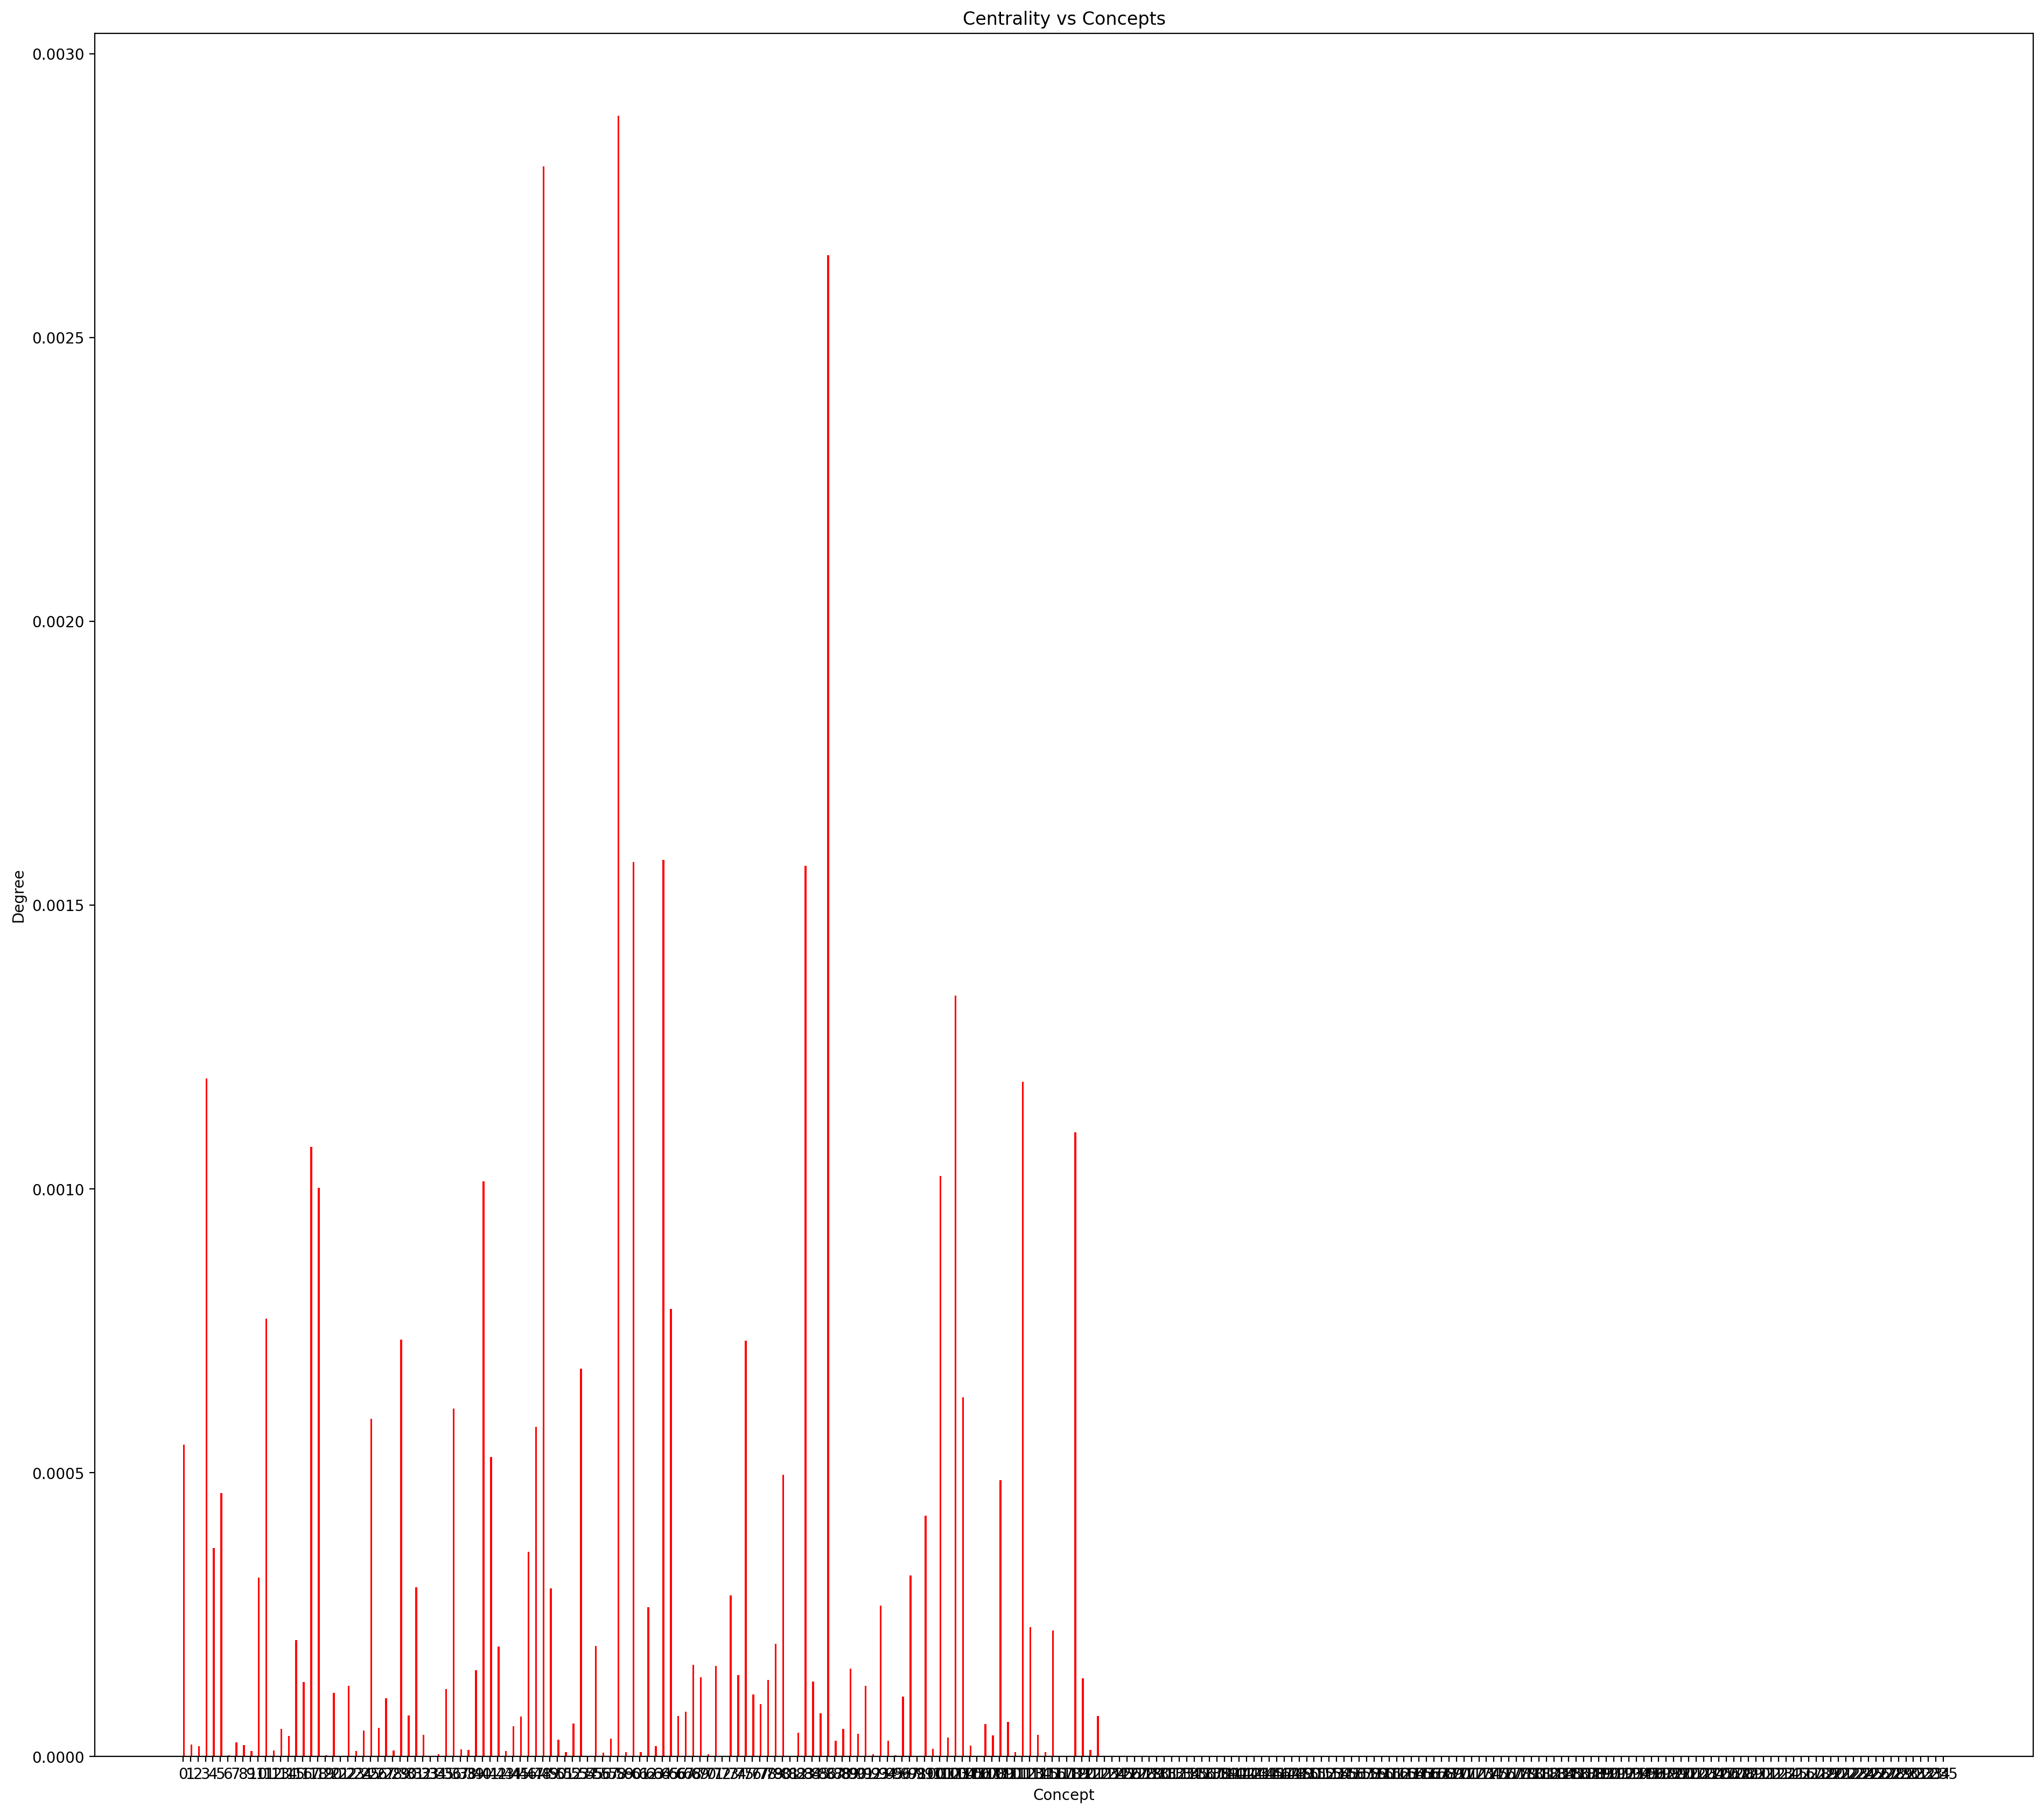

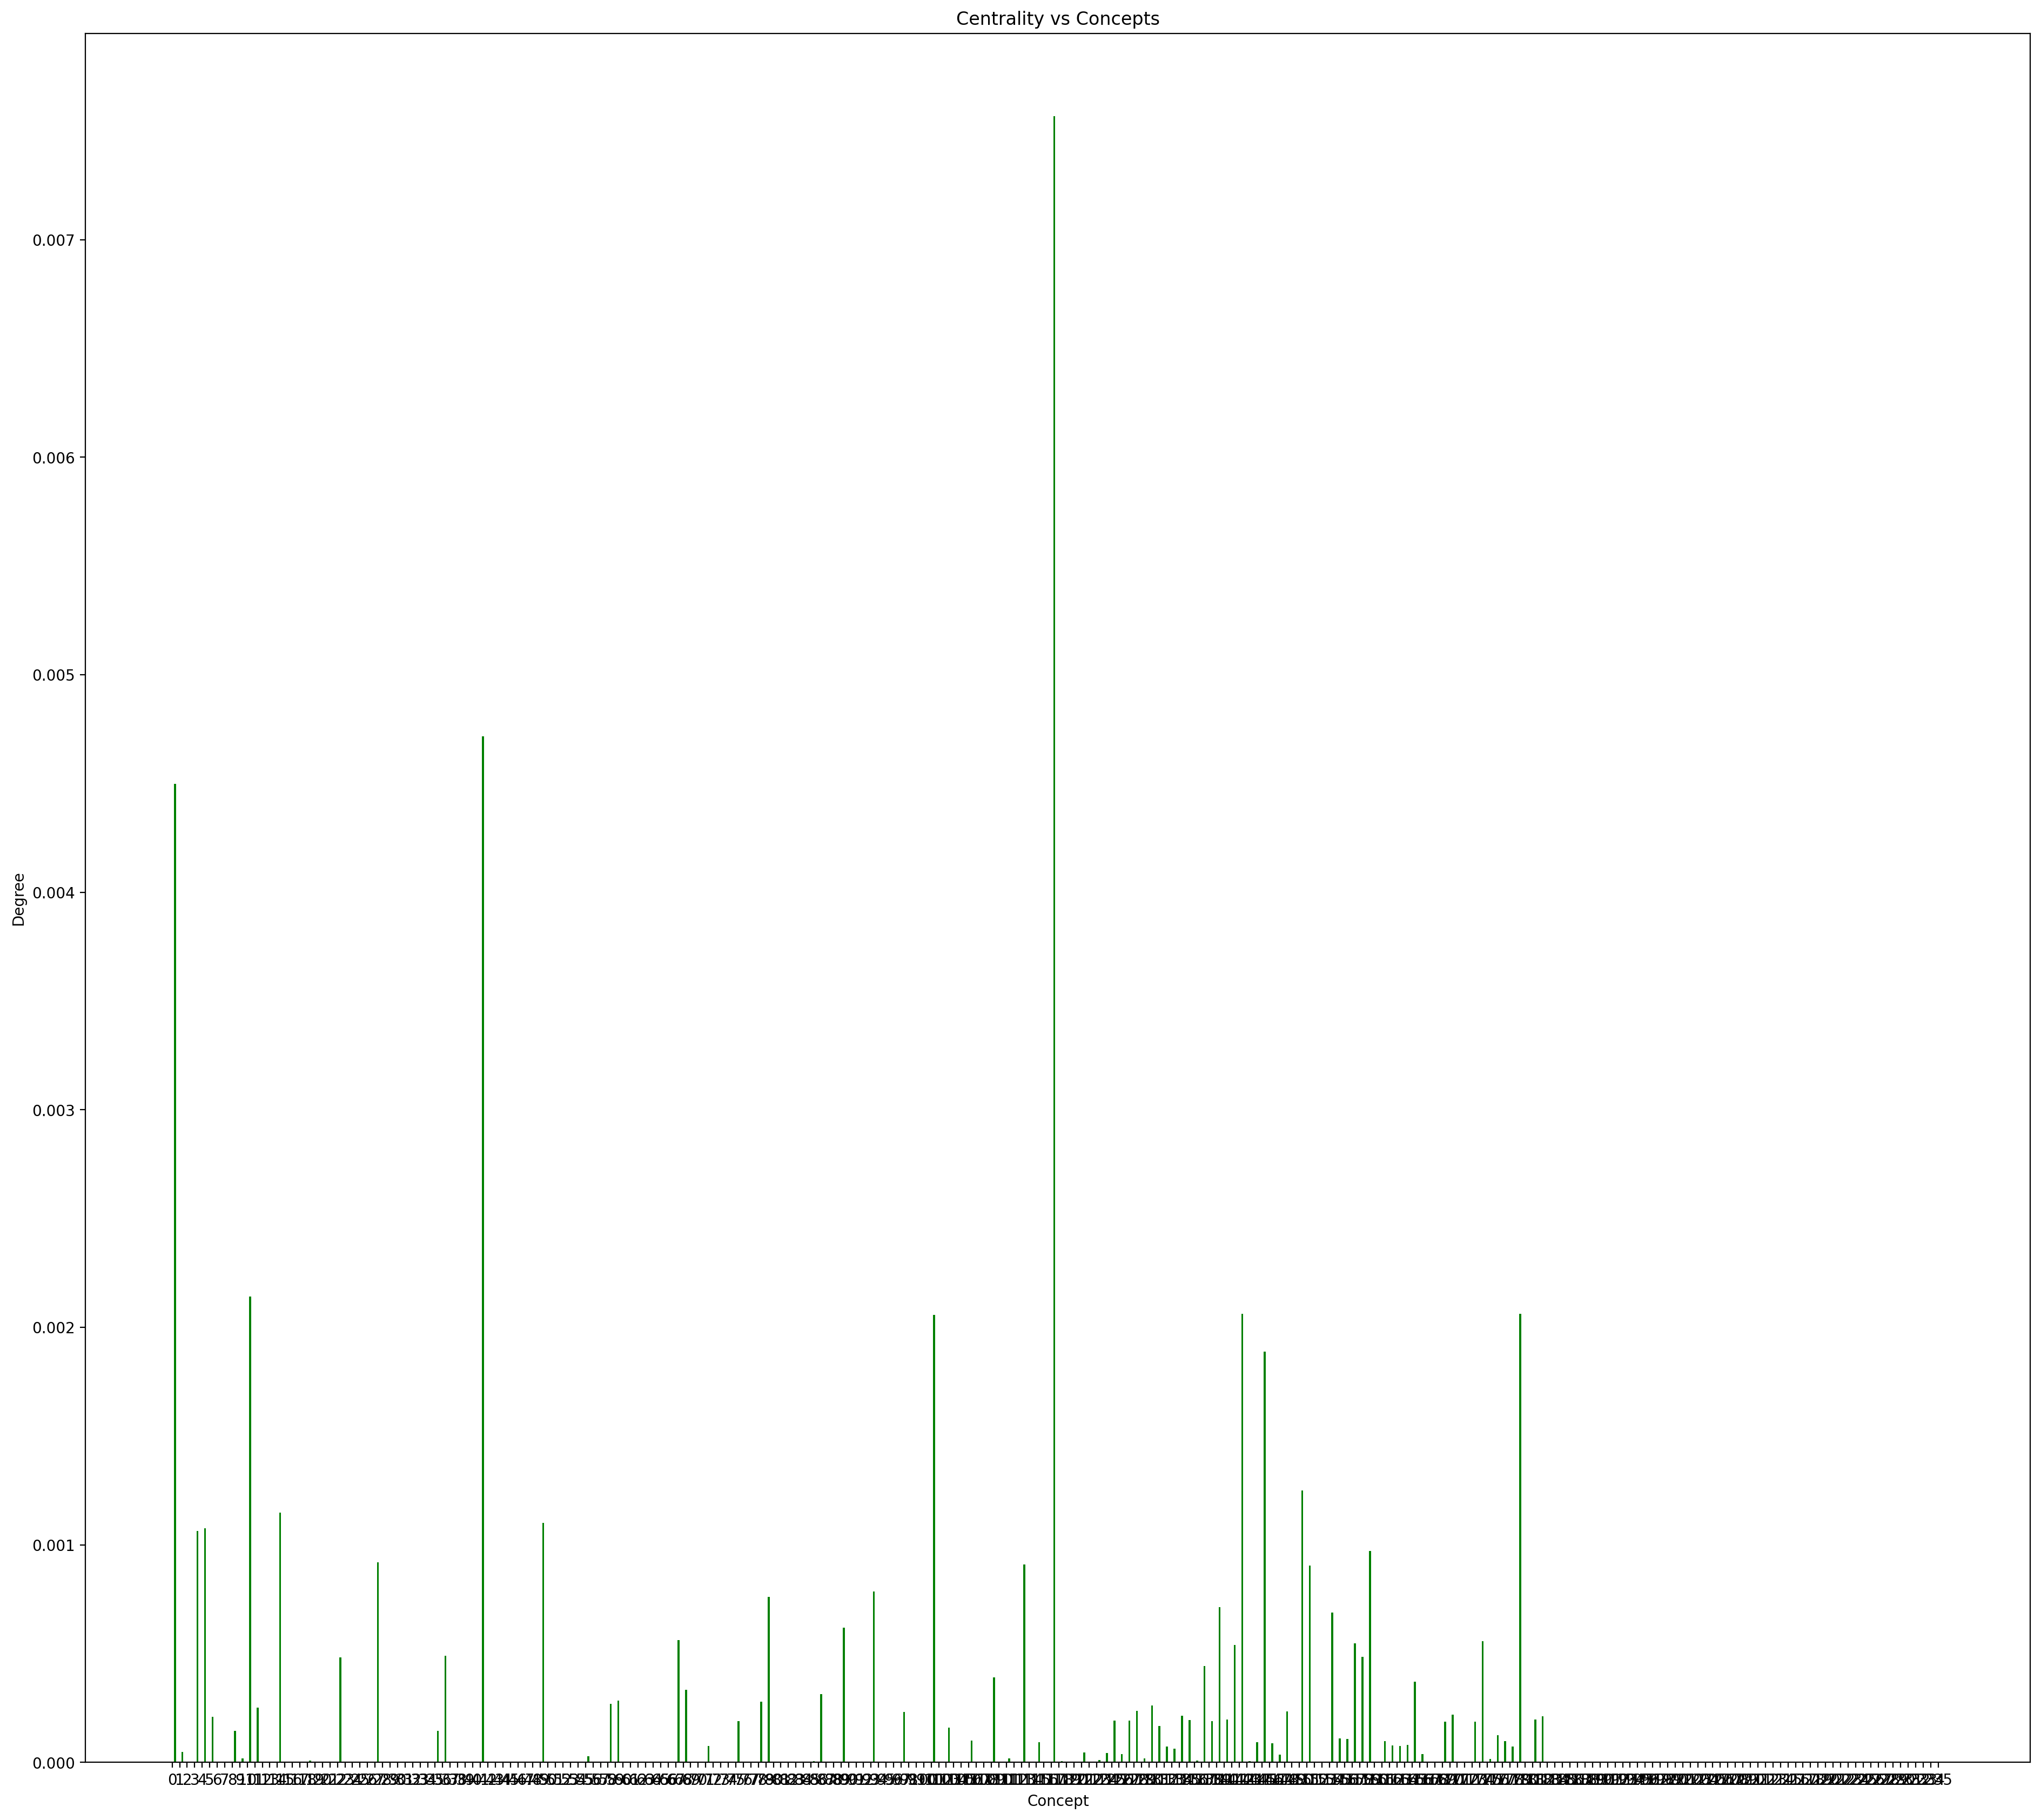

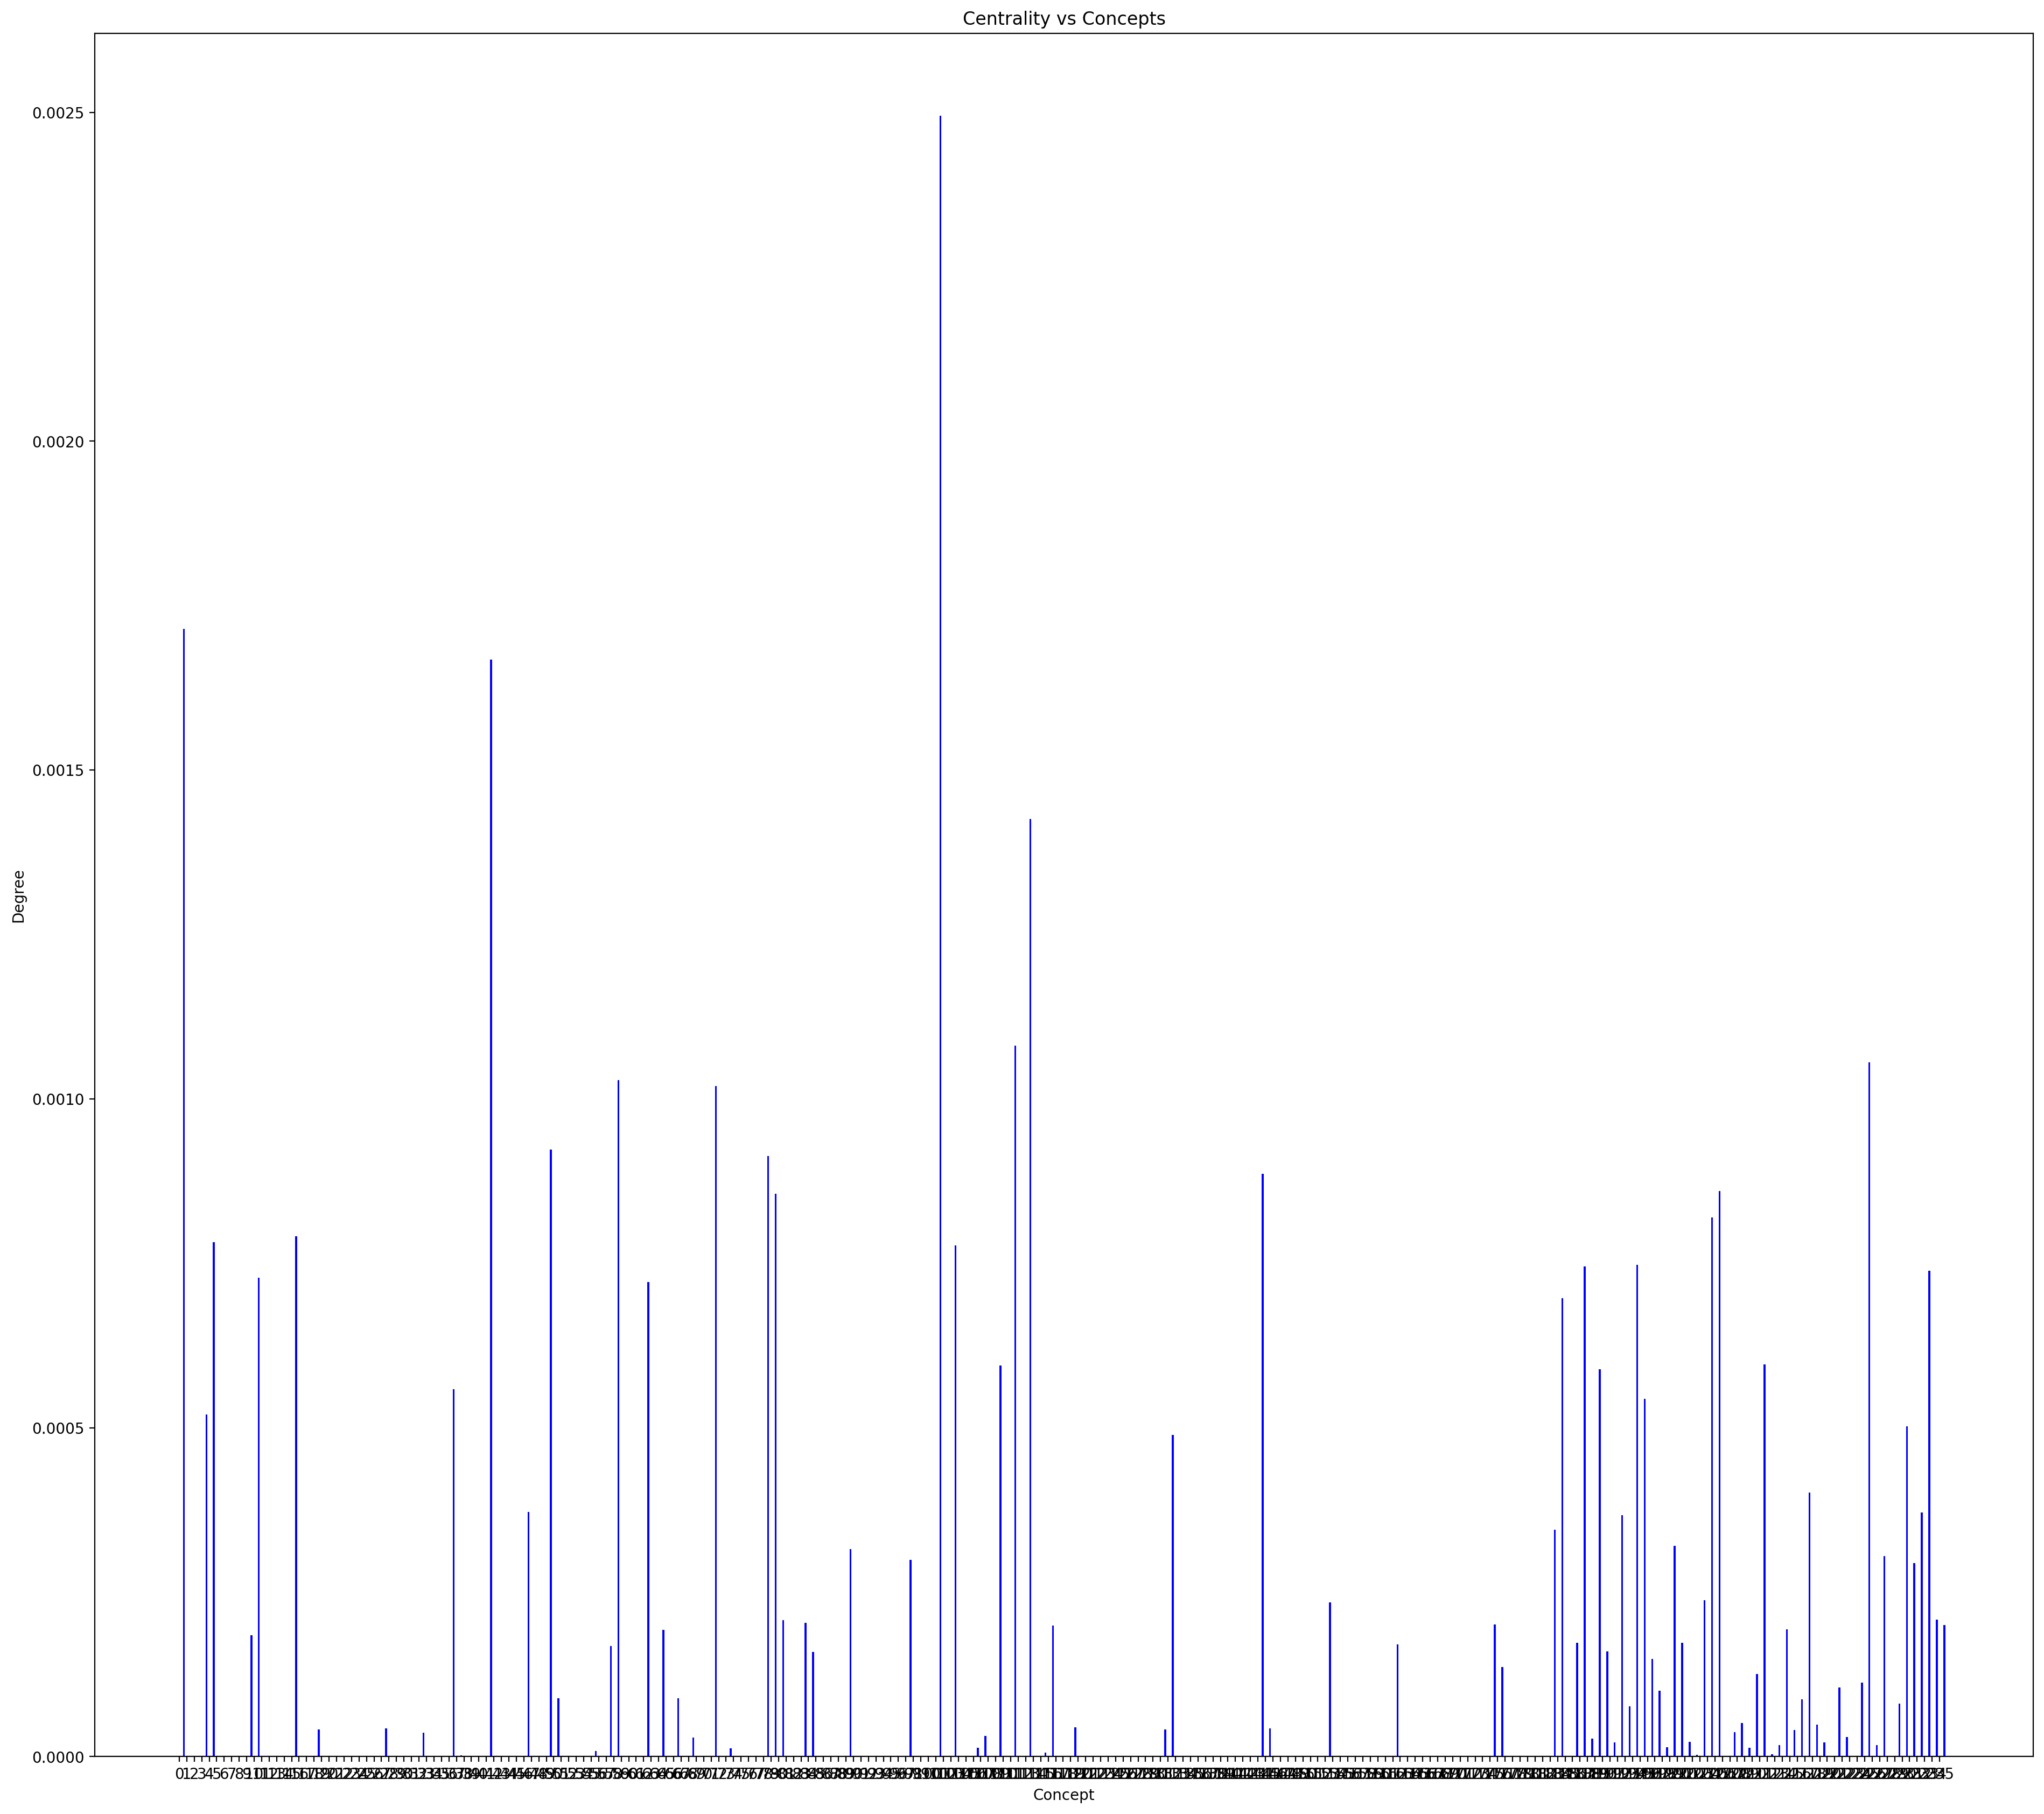

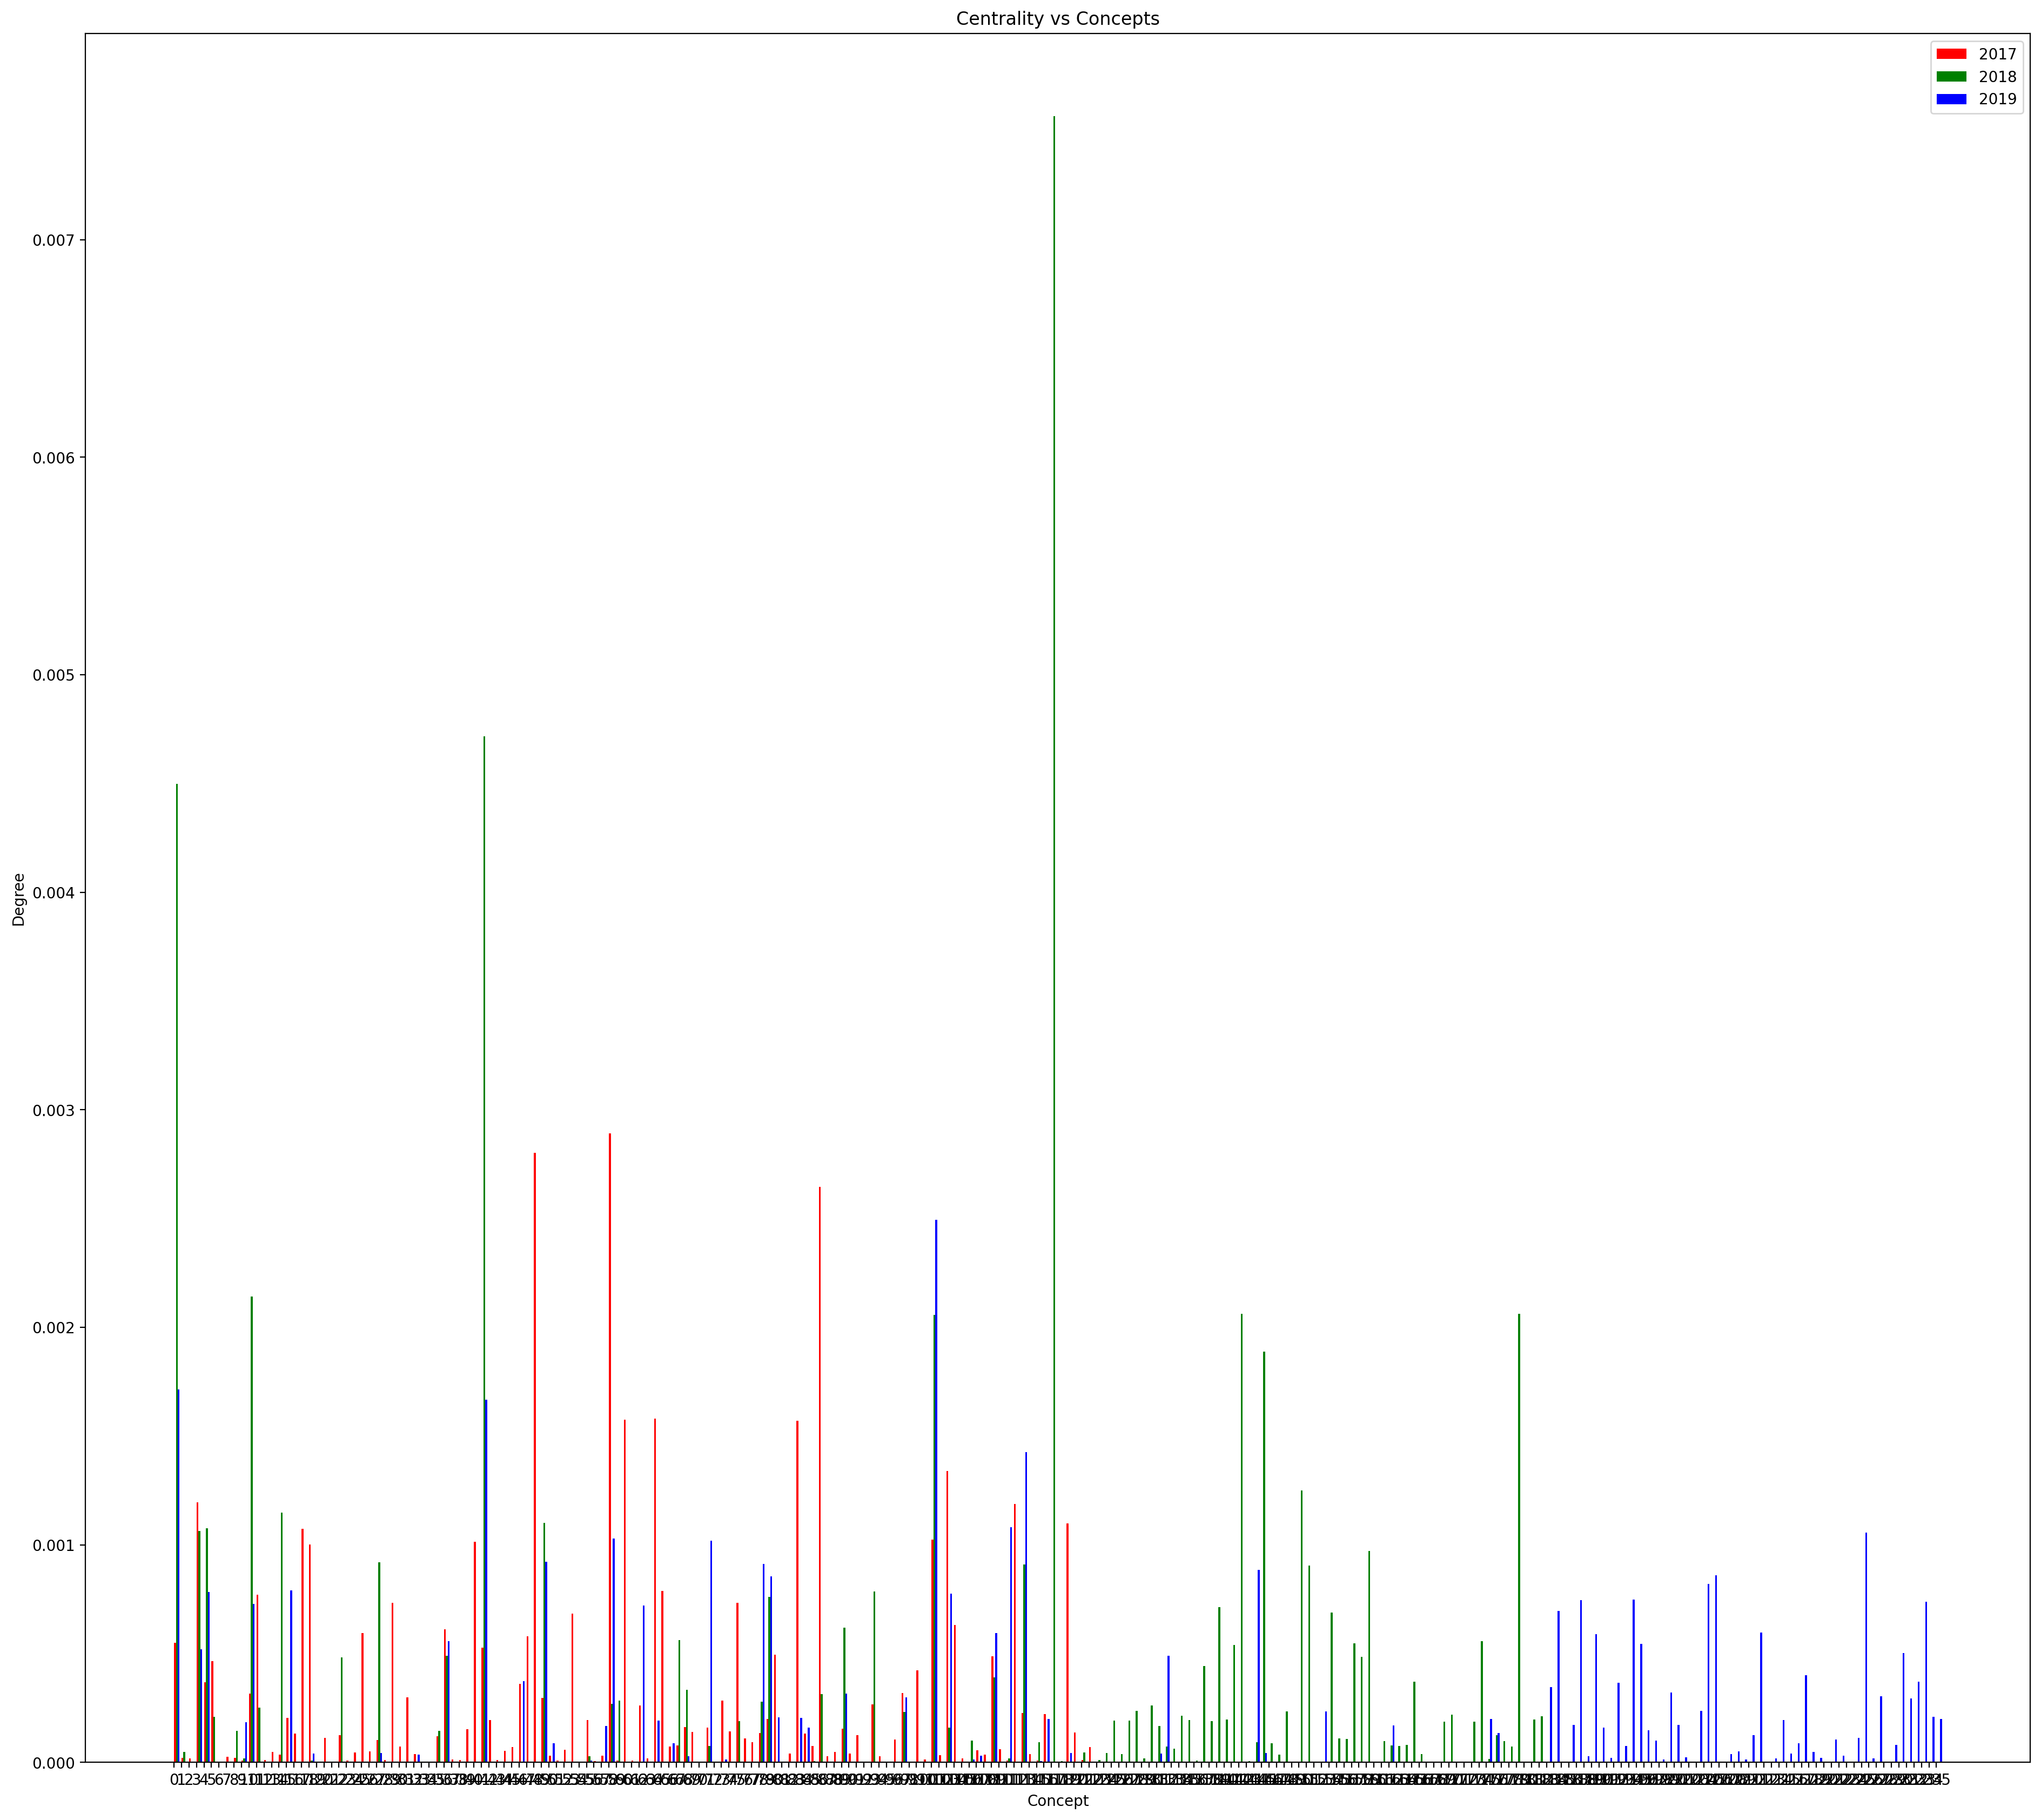

In [ ]:
print('EIGENVECTOR CENTRALITY')
plot_all(eig_centrality)

{rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/knowledge_bases'): [0.0005501353660212553, 0.0044981618588587815, 0.0017150652571132953], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/rdf_graph'): [0.001195202397757724, 0.0010636041319471987, 0.000520622479715721], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/semantics'): [0.0003678988935951739, 0.0010762075993048861, 0.0007822619398606047], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/database'): [0, 0.00016818092599342694, 4.127207384179609e-05], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/interactive_exploration'): [1.8517087440035324e-05, 0, 0], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/user_interfaces'): [0, 1.0219720656225706e-05, 0], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/syntactic_information'): [0, 0, 0.00034534244437941467], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/rdf_data'): [0.002891154771029406, 0.00026851807457127557, 0.001028856302698468]

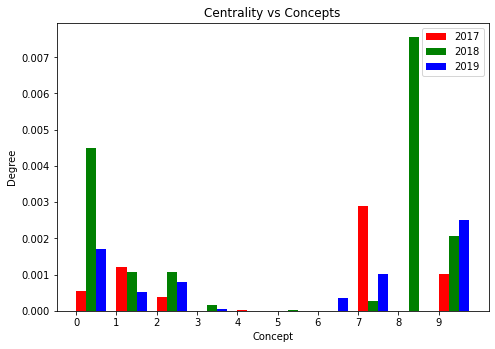

In [ ]:
eig_examples = get_examples(eig_centrality)
plot_combined(eig_examples)
print(eig_examples)

In [ ]:
bet_centrality = get_centrality(nx.betweenness_centrality)

Top 20 values for 2017
 - https://cso.kmi.open.ac.uk/topics/semantics: 0.00099248431072523
 - https://cso.kmi.open.ac.uk/topics/linguistics: 0.00025029305557149983
 - https://cso.kmi.open.ac.uk/topics/reasoner: 0.00025029305557149983
 - https://cso.kmi.open.ac.uk/topics/optimization: 0.0002238133325878283
 - https://cso.kmi.open.ac.uk/topics/inference: 0.0001812685129845691
 - https://cso.kmi.open.ac.uk/topics/word_embedding: 0.0001571039520205656
 - https://cso.kmi.open.ac.uk/topics/rdf_graph: 0.0001479148127727987
 - https://cso.kmi.open.ac.uk/topics/knowledge_base: 0.00010712013918880816
 - https://cso.kmi.open.ac.uk/topics/natural_languages: 8.497765237596385e-05
 - https://cso.kmi.open.ac.uk/topics/natural_language_questions: 7.173562432446903e-05
 - https://cso.kmi.open.ac.uk/topics/query_languages: 7.054532966657158e-05
 - https://cso.kmi.open.ac.uk/topics/ontology_alignment: 6.710596920278533e-05
 - https://cso.kmi.open.ac.uk/topics/description_logics: 6.535217702070797e-05
 - 

BETWEENNESS CENTRALITY


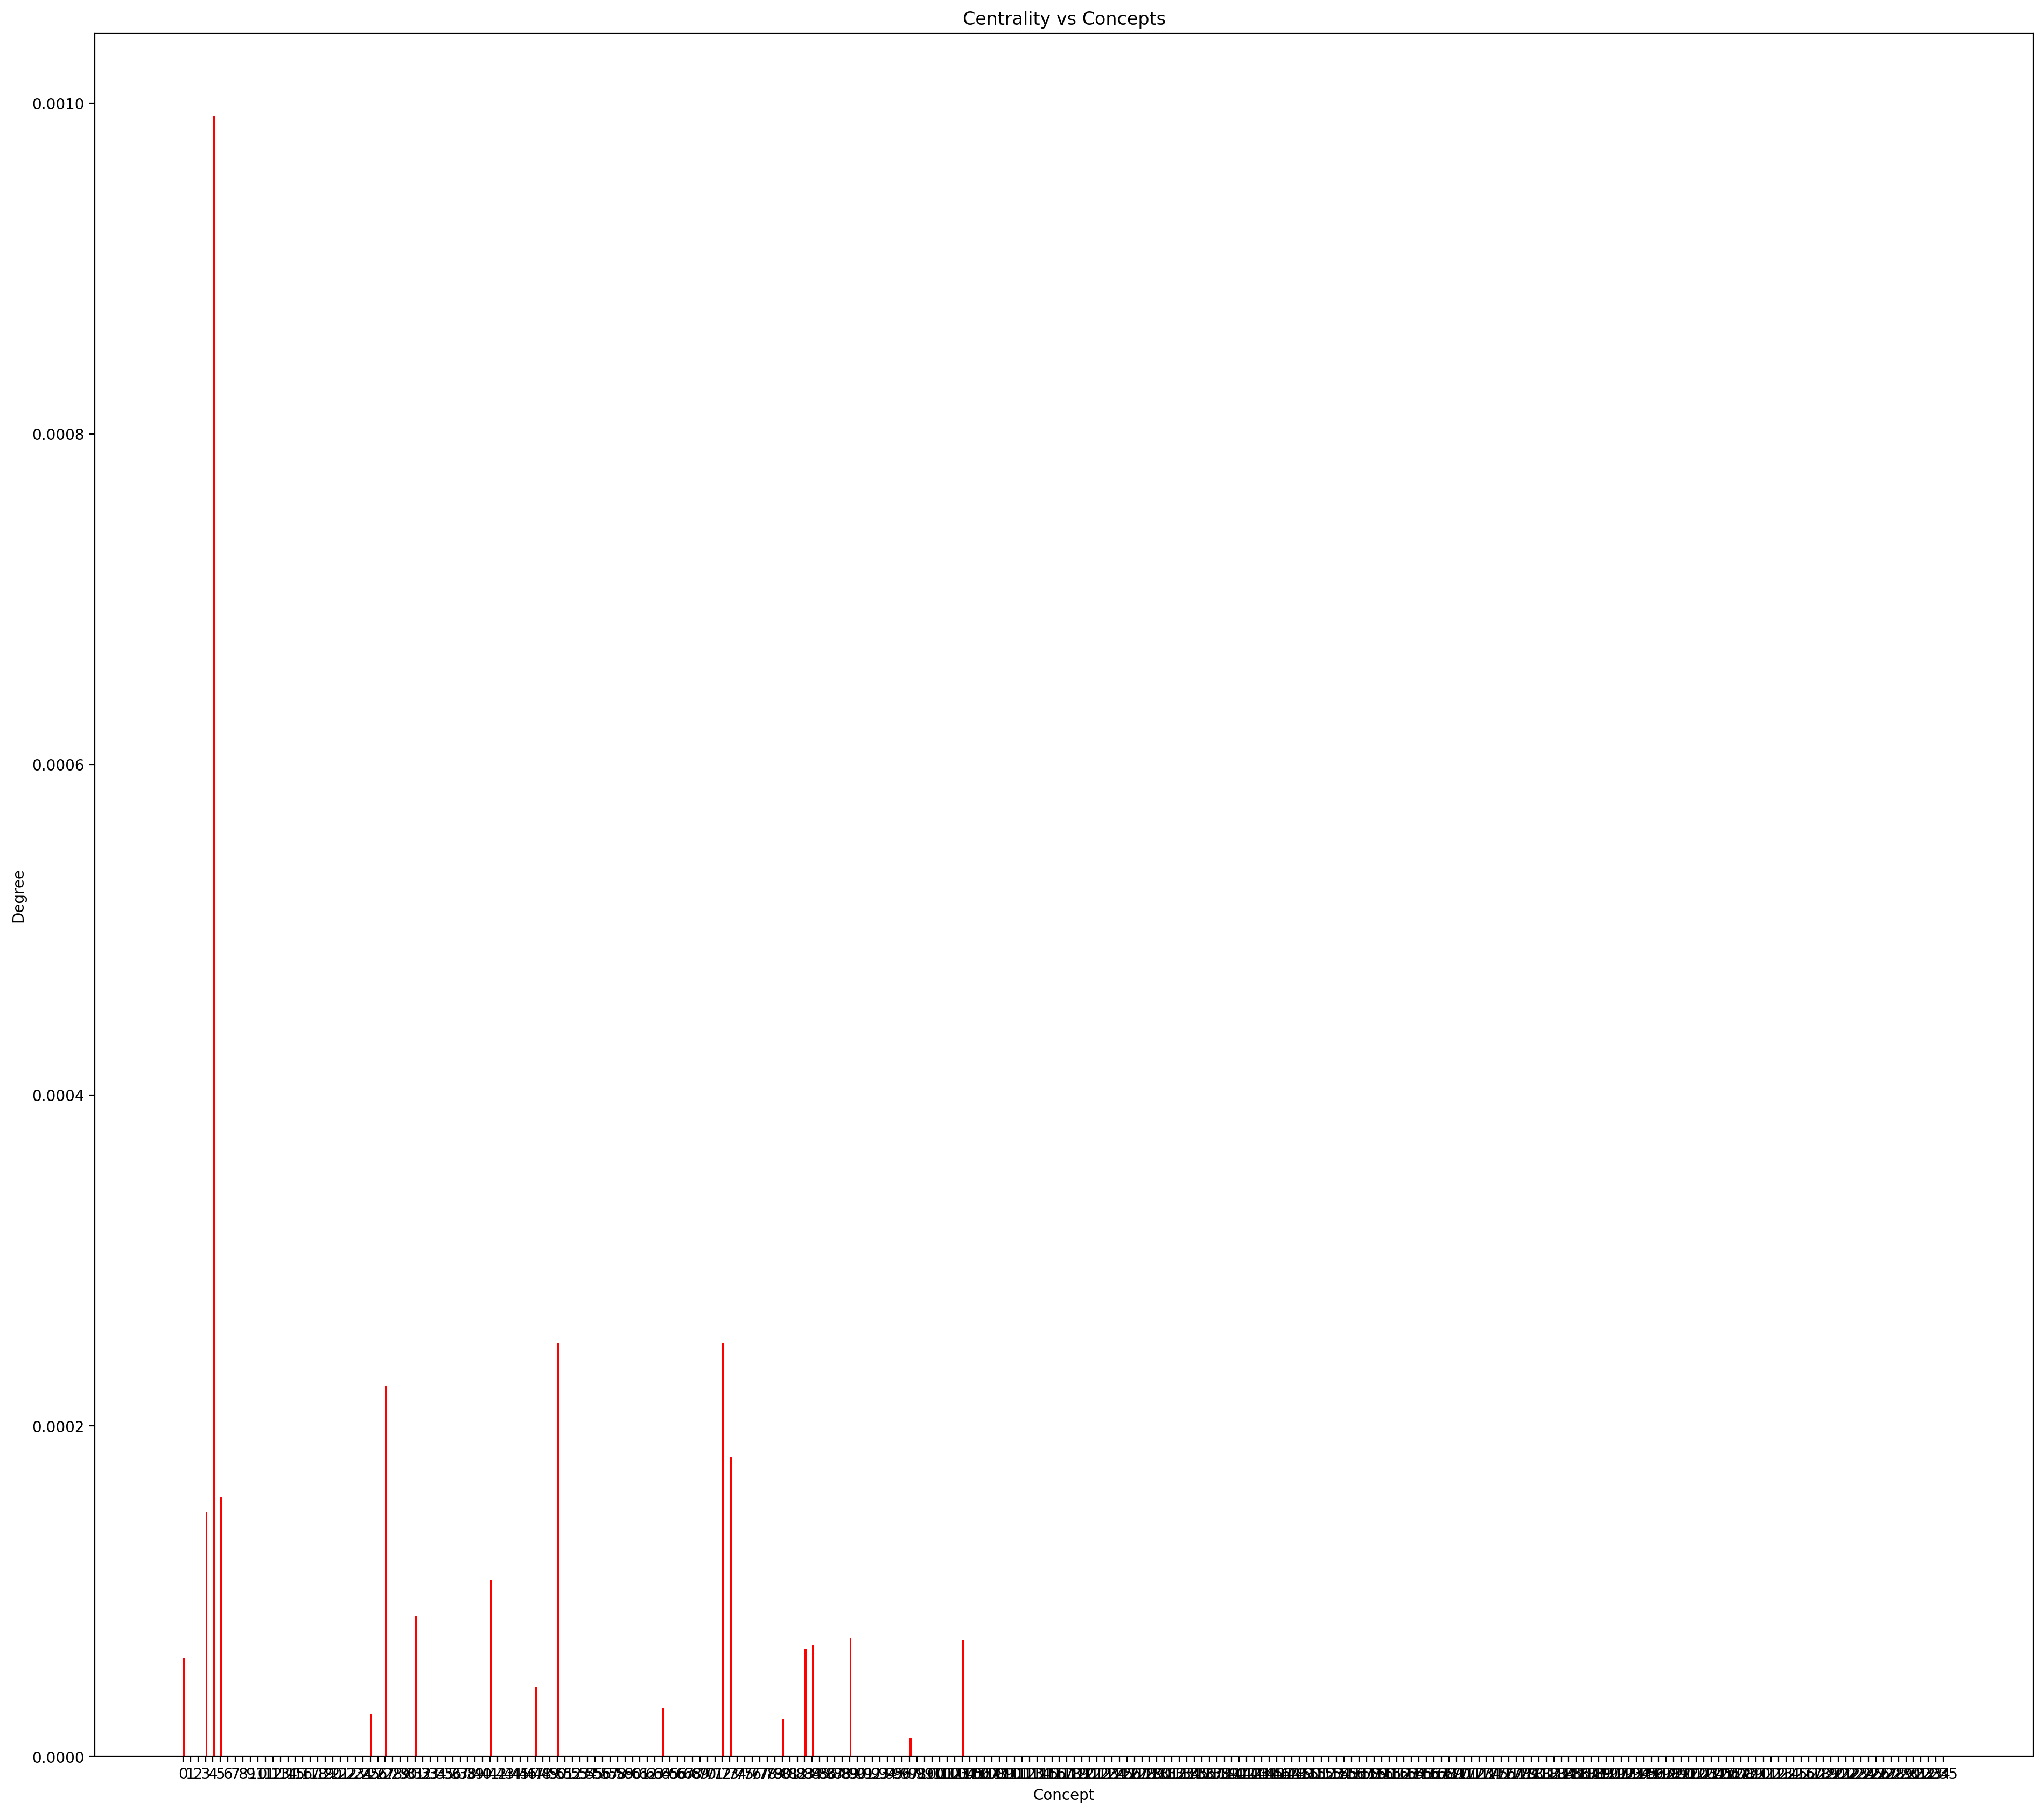

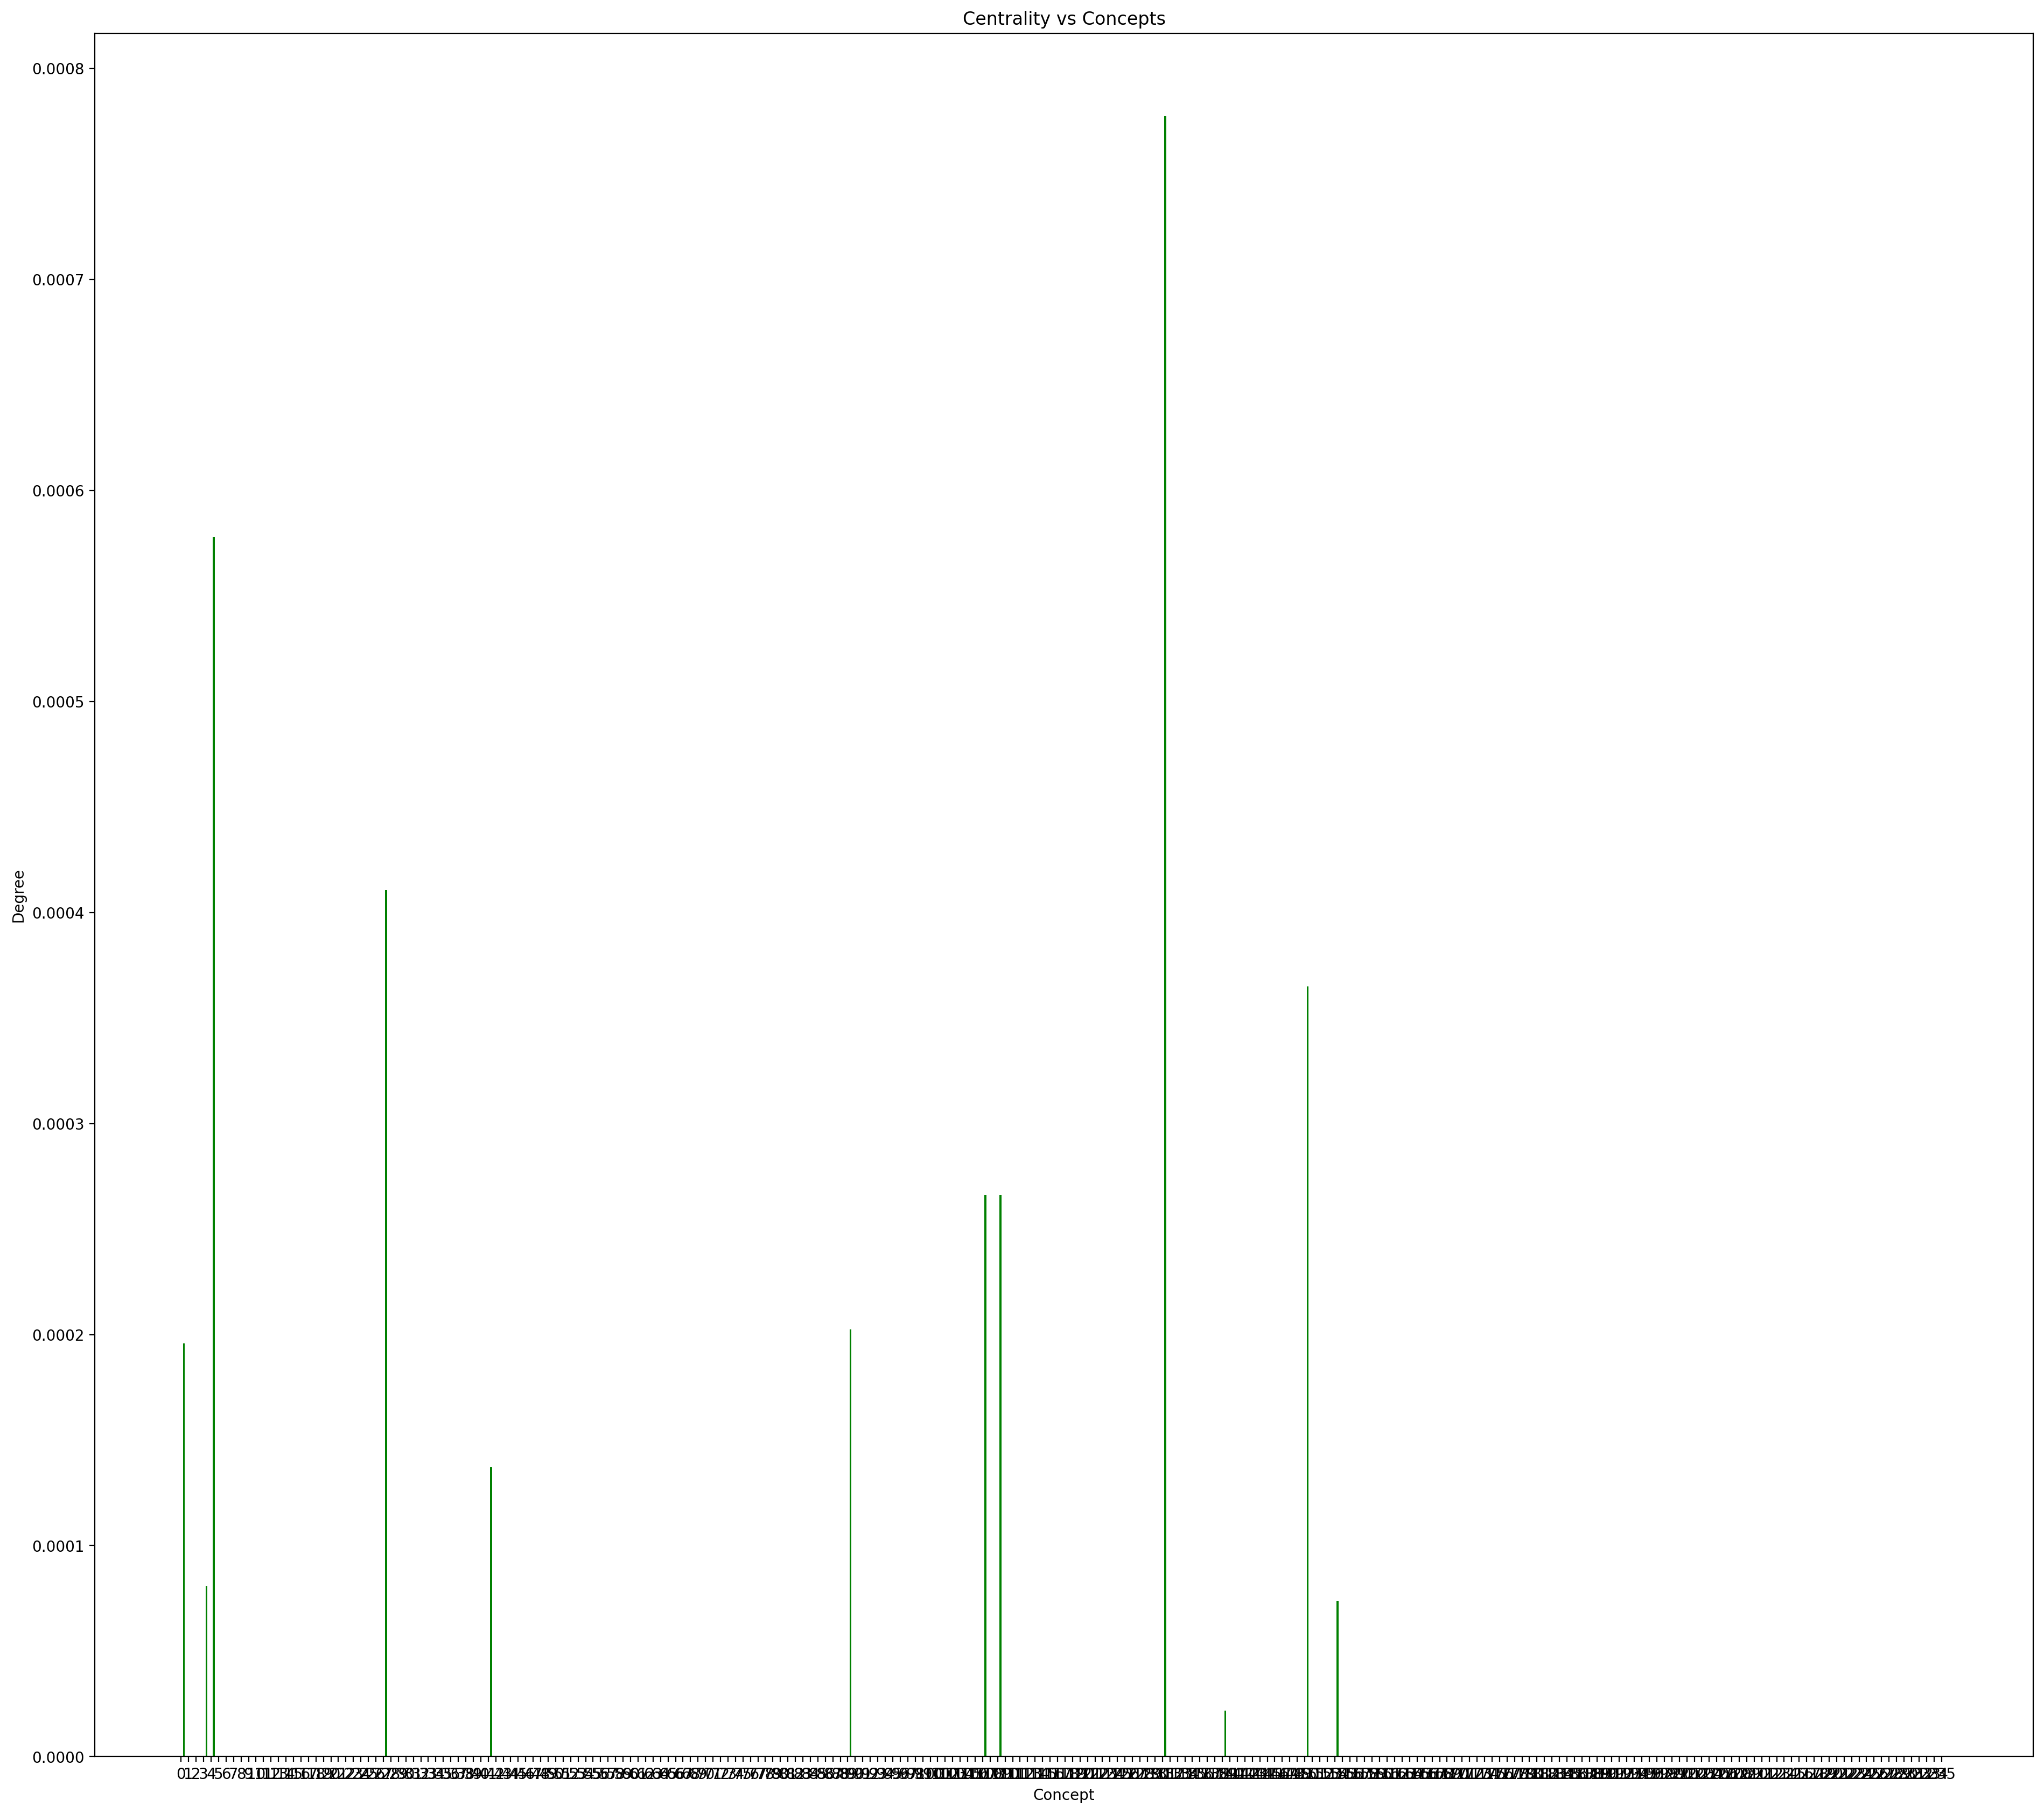

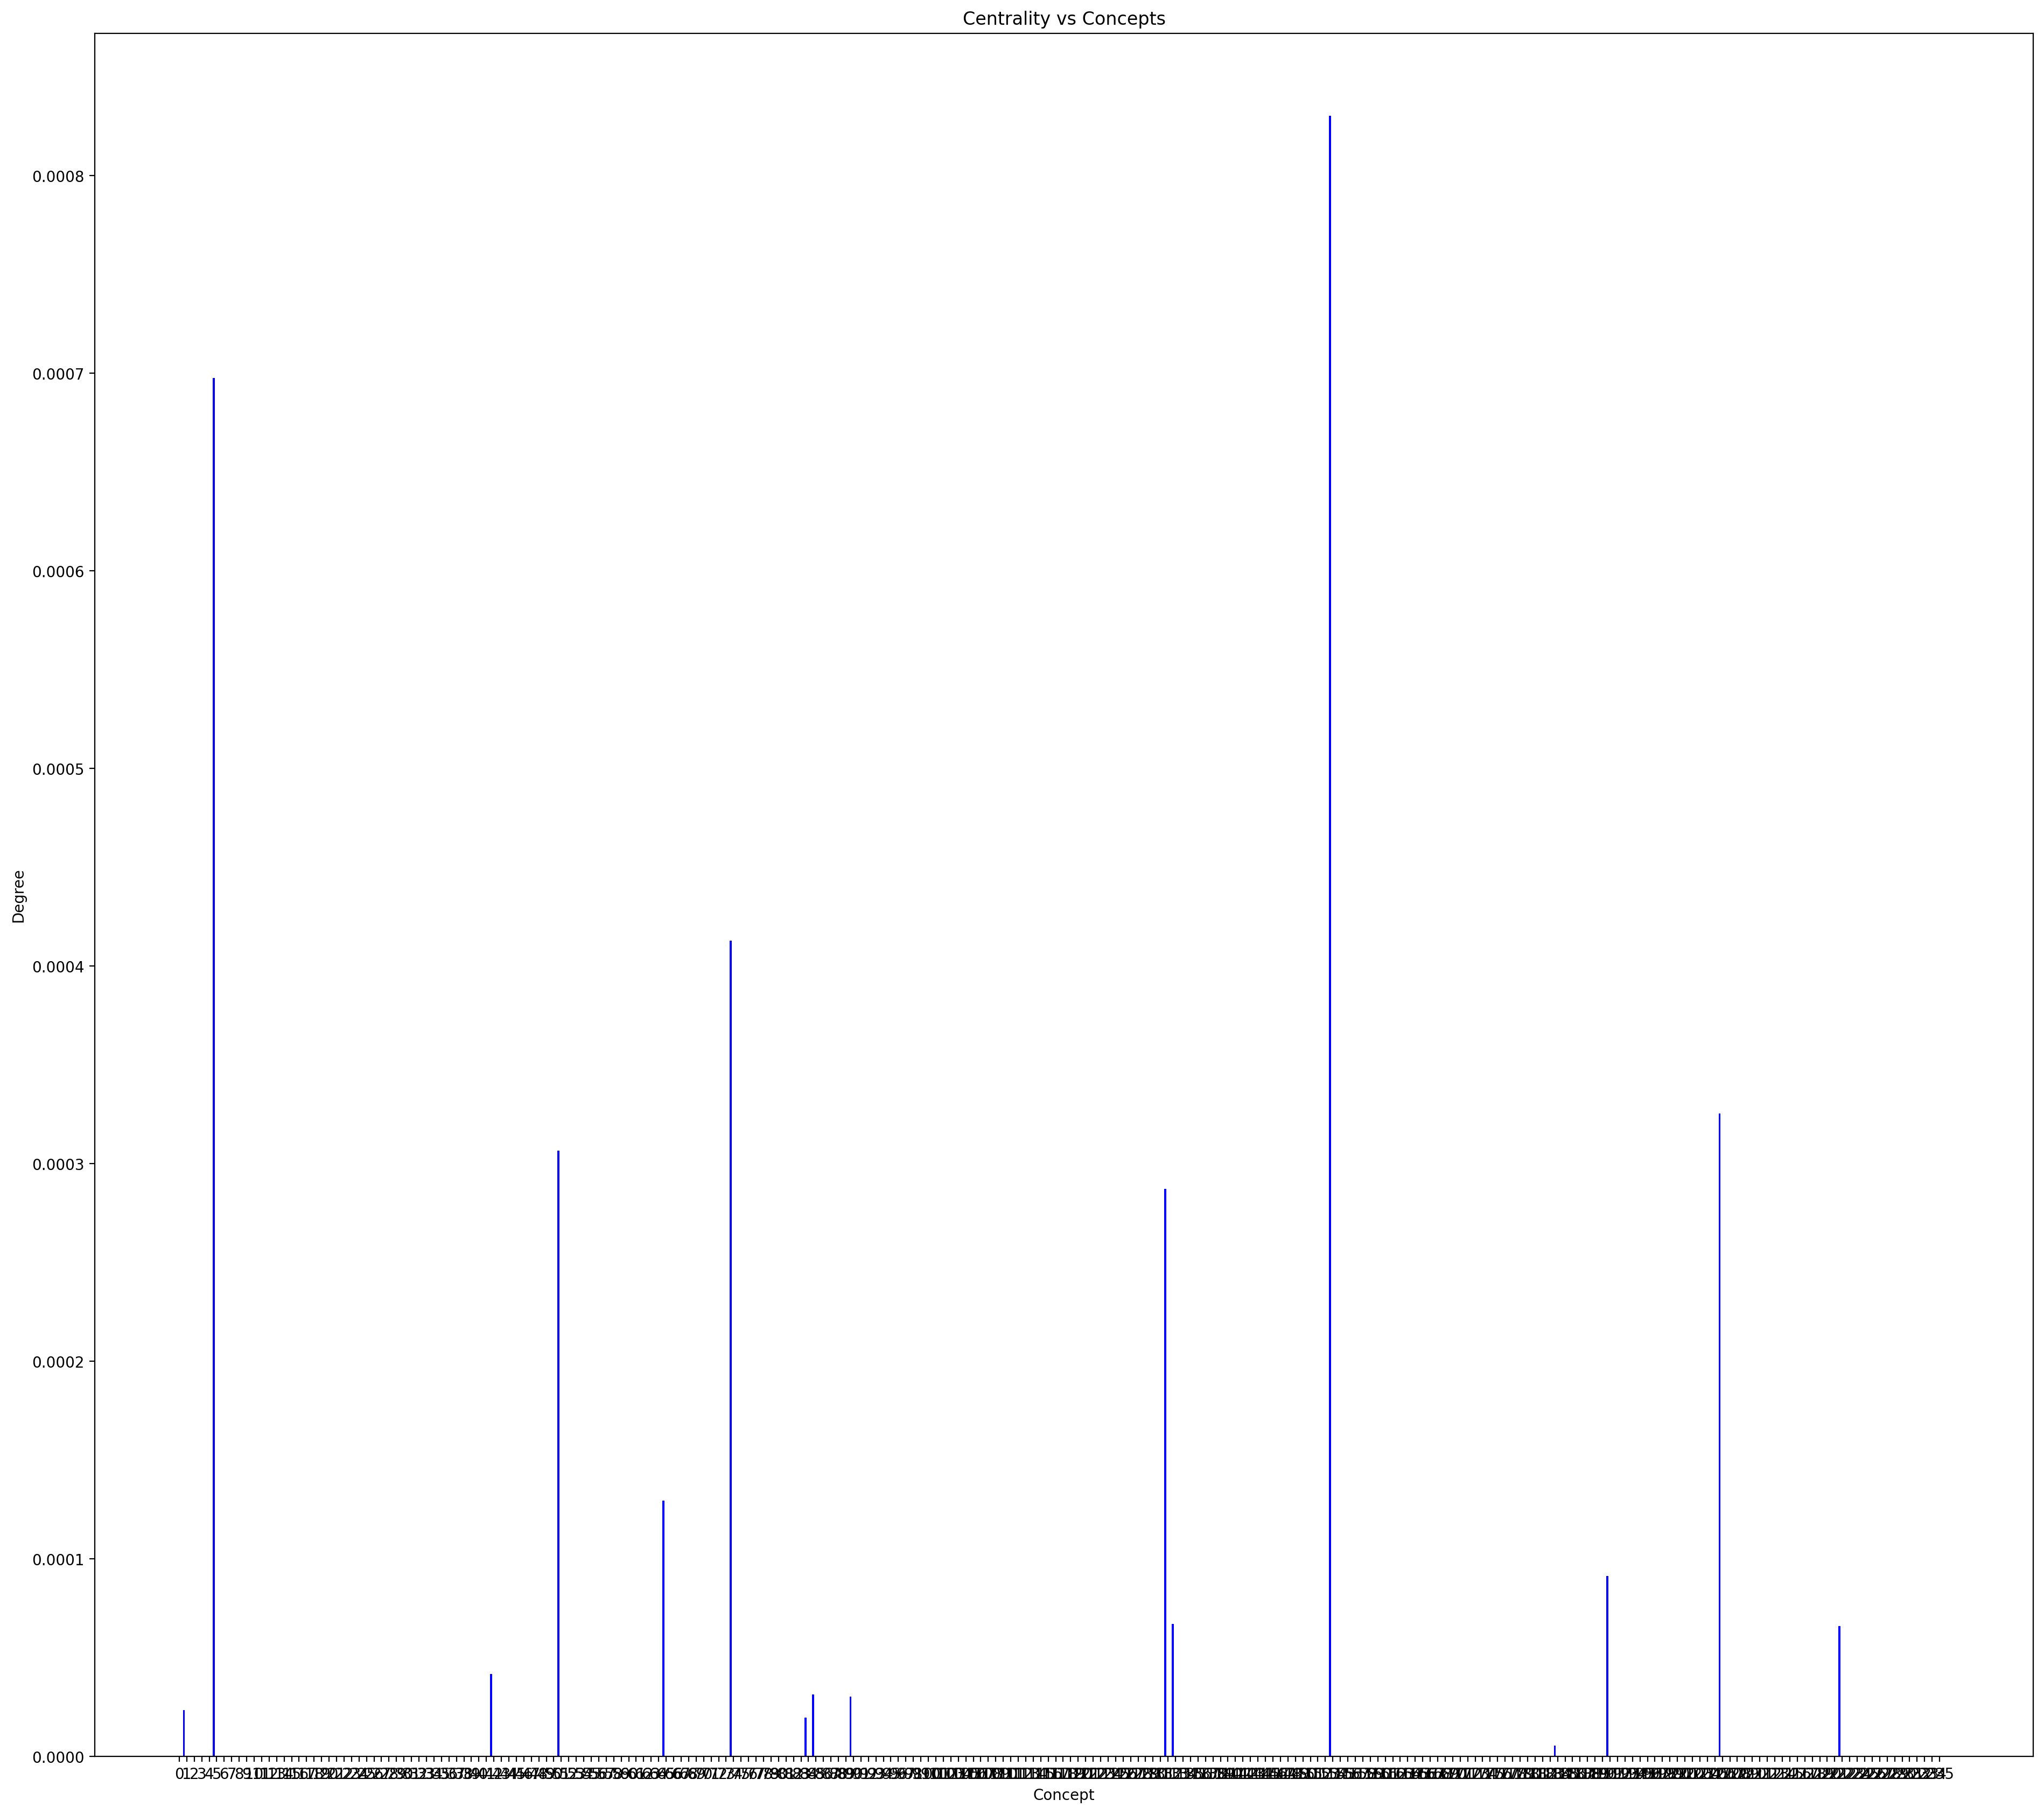

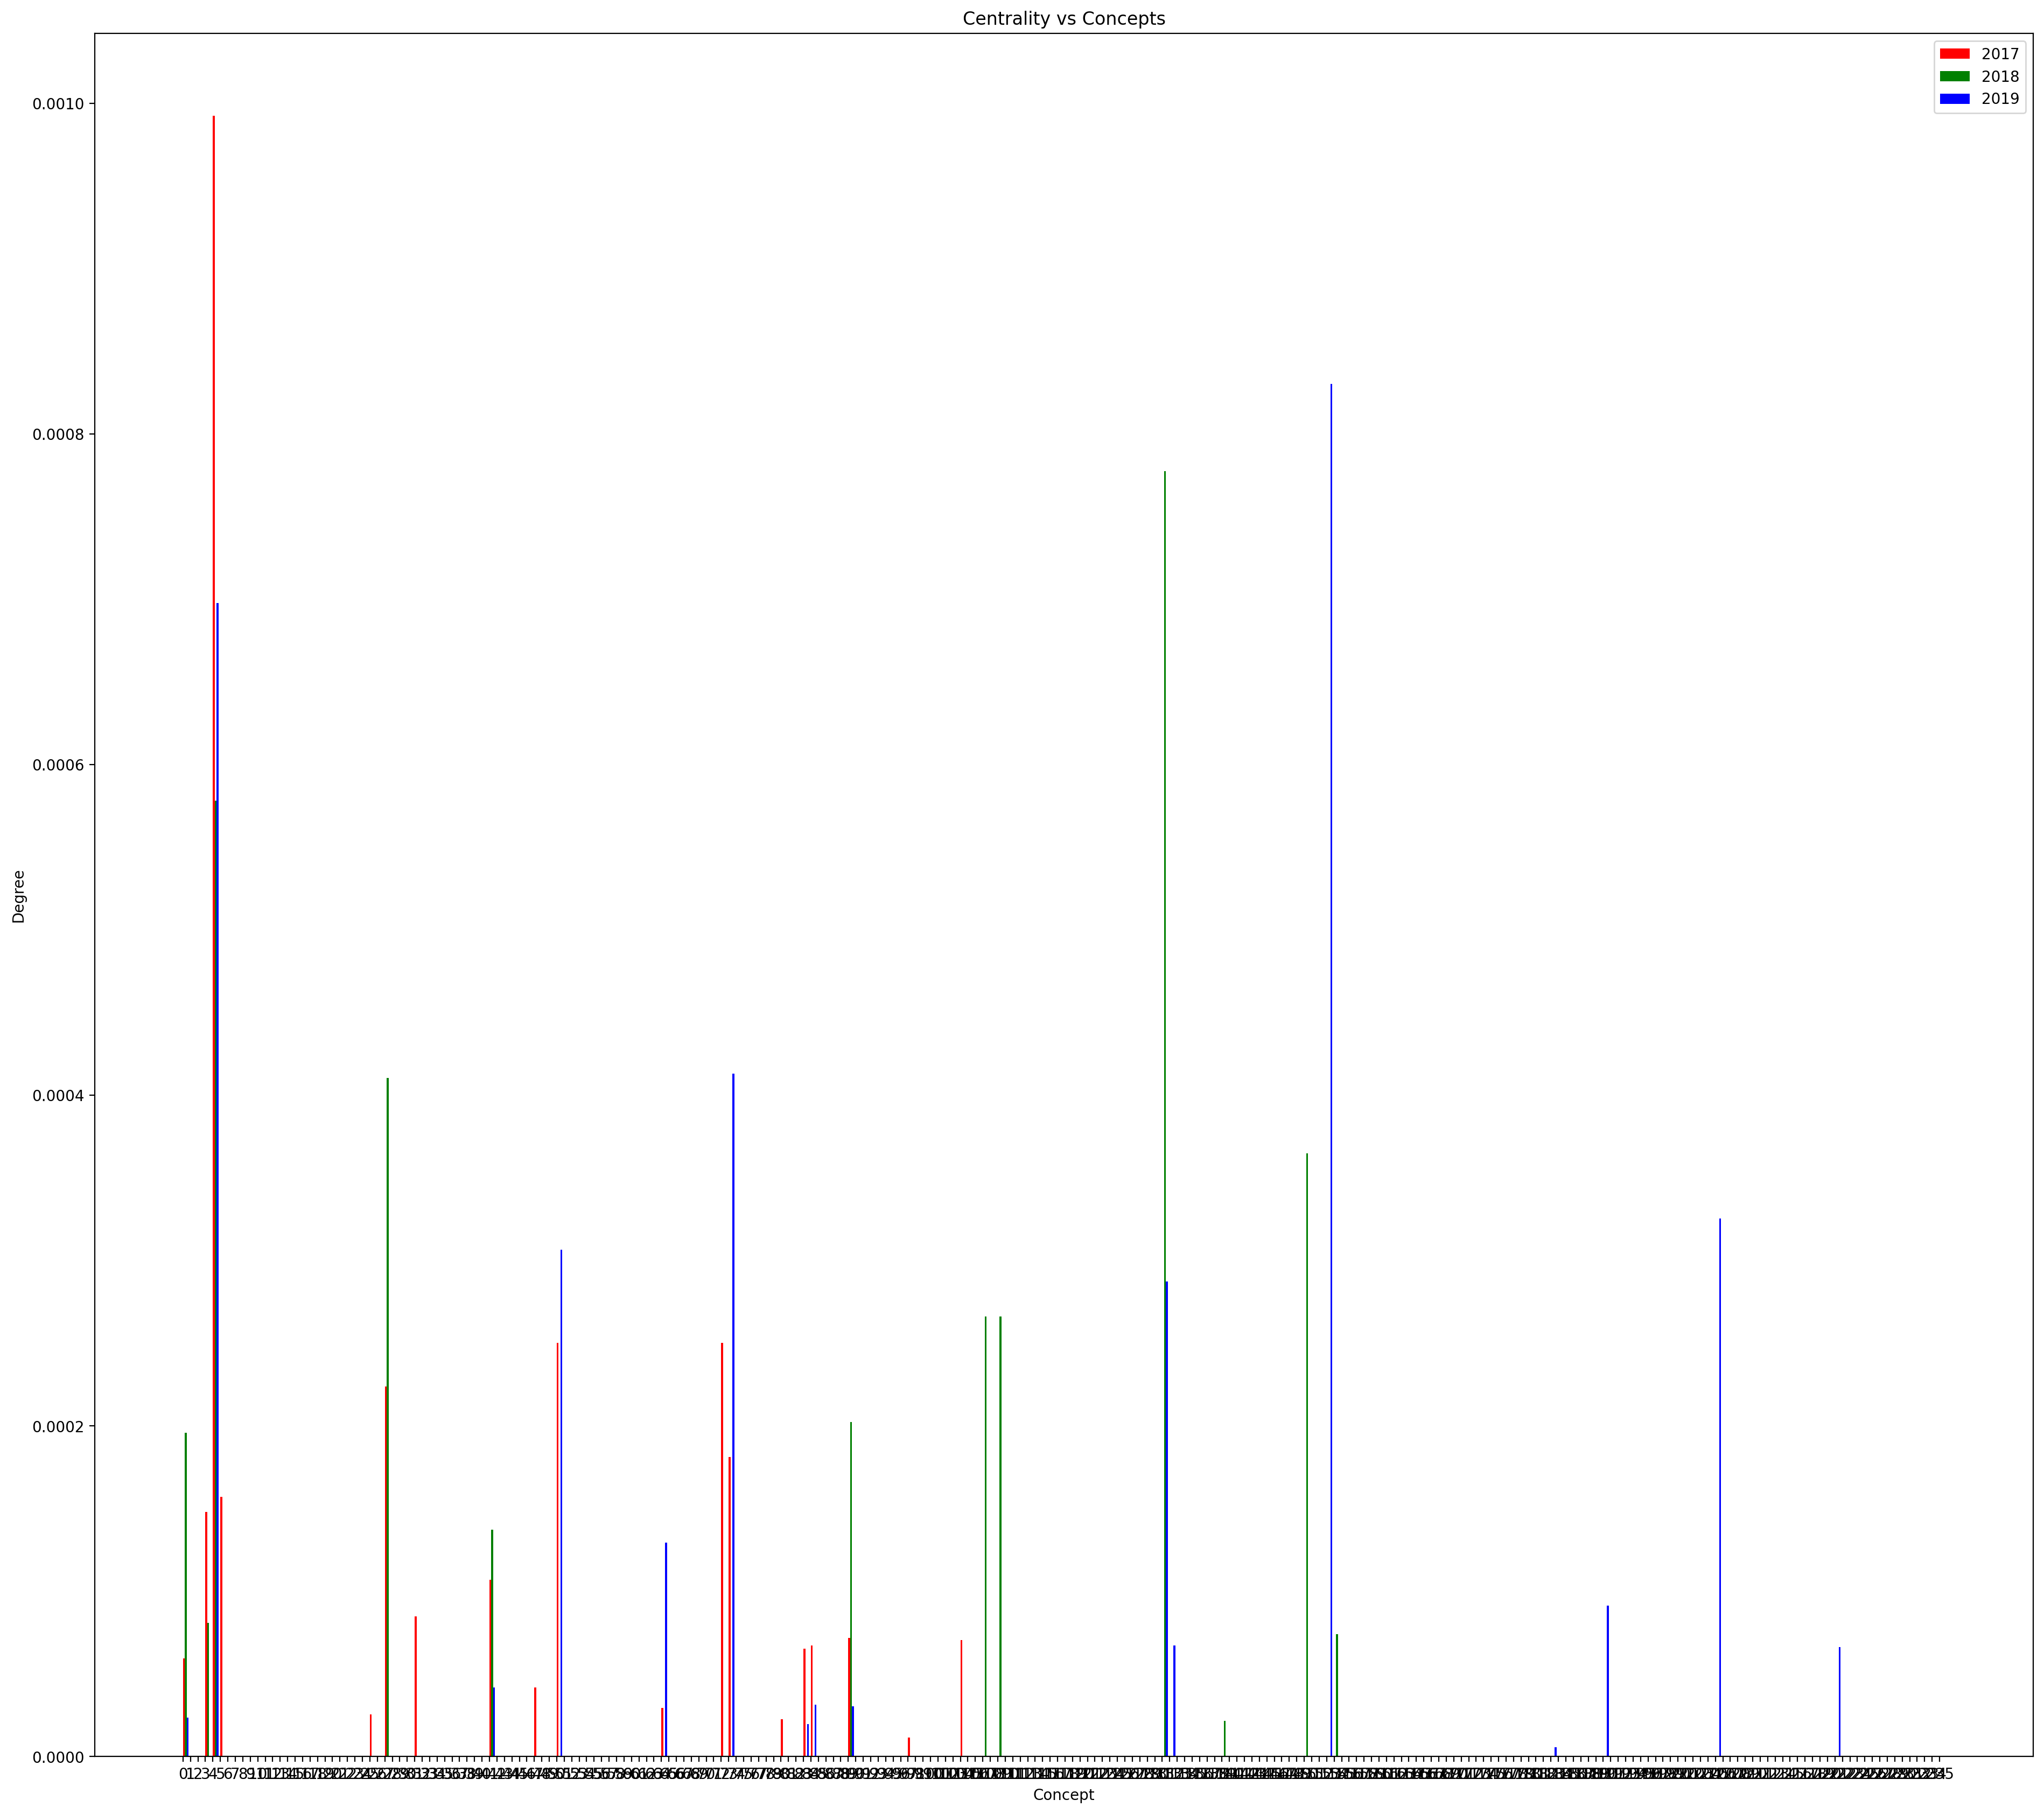

In [ ]:
print('BETWEENNESS CENTRALITY')
plot_all(bet_centrality)

{rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/knowledge_bases'): [5.9519718408858156e-05, 0.00019586301853393971, 2.3437813813215767e-05], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/semantics'): [0.00099248431072523, 0.0005780947197250571, 0.0006977190082097216], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/knowledge_base'): [0.00010712013918880816, 0.00013721269108119, 4.186173285846252e-05], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/database'): [0, 0.0007775264135051178, 0.00028728460382422674], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/word_embedding'): [0.0001571039520205656, 0.0, 0], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/recommendation'): [0.0, 0.00026614594038460885, 0.0], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/neural_network_model'): [0, 0.0, 6.708620027805425e-05], rdflib.term.URIRef('https://cso.kmi.open.ac.uk/topics/dialogue'): [0, 0.0, 0.0008304004233523988]}


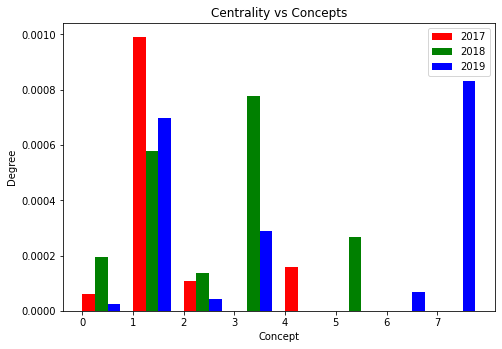

In [ ]:
bet_examples = get_examples(bet_centrality)
plot_combined(bet_examples)
print(bet_examples)